### Cournot Duopoly

- There are two firms that interact in repeated Cournot duopoly game.
- Costs: c1,c2
- Demand: P = 1-Q

#### Cases:
- No discounting, no state
- Discounting and no state
- Discoutning and state

### Import Packages

In [1]:
from itertools import count
import torch
import math
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (30, 10)
plt.rcParams['font.size']=20

### Game 

In [2]:
def P(Q):
    return max(1-Q,0)
    
class firm:
    def __init__(self, c):
        self.c = c
    
    def profit(self,p,q):
        return (p-self.c)*q
    
    def bestresponse(self, q_other):
        return (1-q_other-self.c)/2 
    
def profit(q1,q2):
    return (P(q1+q2)-c1)*q1,(P(q1+q2)-c2)*q2

def competition(c1,c2):
    q1c = (1+c2-2*c1)/3
    q2c = (1+c1-2*c2)/3
    Qc = q1c + q2c
    Pc = P(Qc)
    return q1c, q2c, Pc, Qc

def monopoly(c1,c2):
    if c1<c2:
        Qm = (1-c1)/2
        Pm = (1+c1)/2
    if c1<=c2:
        Qm = (1-c2)/2
        Pm = (1+c2)/2
    return Qm,Pm

def gameReward(q1,q2):
    Q = q1 + q2
    p = P(Q)
    π1 = firm1.profit(p,q1)
    π2 = firm2.profit(p,q2)
    return (π1,π2)

def generateGame(c1, c2):
    firm1 = firm(c1)
    firm2 = firm(c2)
    q1c, q2c, Pc, Qc = competition(c1,c2)
    print('Competition', Qc, Pc)
    Qm,Pm = monopoly(c1,c2)
    print('Monopoly', Qm, Pm)
    return q1c, q2c, Pc, Qc, Qm, Qc

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

### Helper Functions

In [3]:
Transition = namedtuple('Transition',('state','next_state','action','reward'))

class ReplayMemory(object):
    # Holds transitions from experience and gives a random batch of transitions for training
    def __init__(self,capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self,*args):
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [4]:
class DQN(nn.Module):
    # Takes in a vector of states and gives out valuations for each action
    def __init__(self, n_obs, n_actions):
        super(DQN,self).__init__()
        self.layer1 = nn.Linear(n_obs, 128)
        self.layer2 = nn.Linear(128,128)
        self.layer3 = nn.Linear(128, n_actions)
    
    def forward(self,x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)  

In [5]:
class Agent:
    def __init__(self, N_STATES, N_ACTIONS, N_MEMORY=10000, BATCH_SIZE=512, GAMMA=0, EPS_START = 0.9, EPS_END = 0.05, EPS_DECAY = 1000, TAU = 0.0001, LR = 1e-5, BETA = 5, ANNEAL = 0.999):
        self.N_STATES = N_STATES
        self.N_ACTIONS = N_ACTIONS
        self.BATCH_SIZE = BATCH_SIZE
        self.GAMMA = GAMMA
        self.EPS_START = EPS_START
        self.EPS_END = EPS_END
        self.EPS_DECAY = EPS_DECAY
        self.LR = LR
        self.TAU = TAU
        self.BETA0 = BETA
        self.BETA = BETA
        self.ANNEAL = ANNEAL
        self.policy_net = DQN(N_STATES,N_ACTIONS)
        self.target_net = DQN(N_STATES,N_ACTIONS)
        self.state = torch.zeros(1,N_STATES)
        self.actions = torch.tensor(np.arange(N_ACTIONS))
        self.memory = ReplayMemory(N_MEMORY)
        self.steps_done = 0
        self.optimizer = optim.AdamW(self.policy_net.parameters(),lr=LR,amsgrad=True)
        self.action_history = []
        self.loss = torch.tensor(1000)
        
agent1 = Agent(4,2)
agent1.actions

tensor([0, 1])

In [6]:
def select_action(agent):
    # Given state selects action either from the DQN or randomly. 
    global steps_done1, steps_done2
    sample = random.random()
    eps_threshold = agent.EPS_END + (agent.EPS_START-agent.EPS_END)*math.exp(-1.*agent.steps_done/agent.EPS_DECAY)
    agent.BETA = agent.BETA0 * agent.ANNEAL ** agent.steps_done
    agent.steps_done += 1

    if sample>eps_threshold:
        with torch.no_grad():
            probs = torch.exp(agent.policy_net(agent.state)/agent.BETA)/torch.sum(torch.exp(agent.policy_net(agent.state)/agent.BETA))
            try:
                index = probs.multinomial(num_samples=1, replacement=True)
                choice = agent.actions[index]
                return torch.tensor([[choice]],dtype=torch.long)
            except: 
                randchoice = random.choice(np.arange(agent.N_ACTIONS))
                return torch.tensor([[randchoice]],dtype=torch.long)
    else:
        randchoice = random.choice(np.arange(agent.N_ACTIONS))
        return torch.tensor([[randchoice]],dtype=torch.long)
    
select_action(agent1)

tensor([[0]])

In [18]:
def update_target_net(agent):
    target_net_state_dict = agent.target_net.state_dict()
    policy_net_state_dict = agent.policy_net.state_dict()
    for key in policy_net_state_dict:
        target_net_state_dict[key] = policy_net_state_dict[key]*agent.TAU+target_net_state_dict[key]*(1-agent.TAU)
    agent.target_net.load_state_dict(target_net_state_dict)

update_target_net(agent1)

In [19]:
def optimize_model(agent):
    if len(agent.memory)<agent.BATCH_SIZE:
        return
    
    # Load data
    transitions = agent.memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_batch = torch.cat(batch.state)
    
    # final state is after simulation is done
    # these are the "s(t+1)" from the transitions
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)),dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # For these batch states we compute optimal policy according to our policy-network
    # Compute Q(s,a) and get actions - these are the actions that would have been taken for each batch state 
    state_action_values = agent.policy_net(state_batch).gather(1,action_batch)
    
    # Compute V(s_t+1)
    next_state_values = torch.zeros(agent.BATCH_SIZE)
    with torch.no_grad():
        # Use the "old" target_net to obtain value (Expected Return) on optimal actions from sampled s(t+1)
        # This is Q_old(s',a')
        next_state_values[non_final_mask] = agent.target_net(non_final_next_states).max(1)[0]
        
    # Here we have add r + max Q_old(s',a')
    expected_state_action_values = (next_state_values*agent.GAMMA)+reward_batch

    # Compute the loss
    # Q_new(s,a) - r + max Q_old(s',a'): is the error
    # Huber loss function
    criterion = nn.SmoothL1Loss()
    agent.loss = criterion(state_action_values,expected_state_action_values.unsqueeze(1))
    agent.optimizer.zero_grad()
    agent.loss.backward()
    torch.nn.utils.clip_grad_value_(agent.policy_net.parameters(),100)
    agent.optimizer.step()   
    

In [20]:
agent1.state.dtype

torch.float32

### HyperParameters and Initializations

In [55]:
BATCH_SIZE = 512 # number of transitions sampled from replay buffer
GAMMA = 0.99 # Discount factor
EPS_START = 0.9 # Initial value of Epsilon
EPS_END = 0.05 # End value of Epsilon
EPS_DECAY = 1000 # controls decay rate of Epsilon
TAU = 0.0005 # update rate of target network
LR = 1e-4 # Learning rate of Adam
BETA = 5 # temperature of the greedy-exploratory policy
ANNEAL = 0.99 # temperature of the greedy-exploratory policy
N_MEMORY = 10000
N_STATES = 1
N_ACTIONS = 50

c1, c2 = 0.1,0.1
firm1 = firm(c1)
firm2 = firm(c2)
q1c, q2c, Pc, Qc, Qm, Qc = generateGame(c1, c2)
Qgrid = np.linspace(0, q1c, N_ACTIONS)
print(Qgrid)
agent1 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA,
                    EPS_START, EPS_END, EPS_DECAY, TAU, 
                    LR, BETA, ANNEAL)
#agent2 = Agent(N_STATES, N_ACTIONS, N_MEMORY, BATCH_SIZE, GAMMA,
#                    EPS_START, EPS_END, EPS_DECAY, TAU, 
#                    LR, BETA, ANNEAL)

Competition 0.6000000000000001 0.3999999999999999
Monopoly 0.45 0.55
[0.         0.00612245 0.0122449  0.01836735 0.0244898  0.03061224
 0.03673469 0.04285714 0.04897959 0.05510204 0.06122449 0.06734694
 0.07346939 0.07959184 0.08571429 0.09183673 0.09795918 0.10408163
 0.11020408 0.11632653 0.12244898 0.12857143 0.13469388 0.14081633
 0.14693878 0.15306122 0.15918367 0.16530612 0.17142857 0.17755102
 0.18367347 0.18979592 0.19591837 0.20204082 0.20816327 0.21428571
 0.22040816 0.22653061 0.23265306 0.23877551 0.24489796 0.25102041
 0.25714286 0.26326531 0.26938776 0.2755102  0.28163265 0.2877551
 0.29387755 0.3       ]


In [60]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx] 

array([27])

In [61]:
epochs = 20000
for t in range(epochs):
    print('\n Iteration:',t)

    # Take action
    a1 = select_action(agent1)
    q1 = Qgrid[a1]
    q2 = torch.tensor(np.maximum(q1,0), dtype = torch.float32)
    a2 = torch.tensor(np.where(Qgrid==find_nearest(Qgrid,q2.item()))[0])
    
    # Obtain Reward
    r1, r2 = gameReward(q1,q2)
    r1 = torch.tensor([r1])
    #r2 = torch.tensor([r2])
    
    # Compute next state
    next_state1 = agent1.state 
    next_state1[0] = a2.item()
    #next_state2 = torch.cat([torch.cat([agent2.state[:,0:int(N_STATES/2)], a1],dim=1), torch.cat([agent2.state[:,int(N_STATES/2)+1:-1], a2],dim=1)], dim=1)
    
    # store memory in transition
    agent1.memory.push(agent1.state, next_state1, a1, r1)
    #agent2.memory.push(agent1.state, next_state2, a2, r2)

    # move to next state
    agent1.state = next_state1
    #agent2.state = next_state2
    
    # optimize
    optimize_model(agent1)
    #optimize_model(agent2)

    # soft update target_net
    update_target_net(agent1)
    #update_target_net(agent2)
    
    # record actions
    agent1.action_history.append(a1.item())
    #agent2.action_history.append(a2.item())
    
    # print loss
    print('Loss Agent 1:', agent1.loss.item())
    #print('Loss Agent 2:', agent2.loss.item())



 Iteration: 0
Loss Agent 1: 1000

 Iteration: 1
Loss Agent 1: 1000

 Iteration: 2
Loss Agent 1: 1000

 Iteration: 3
Loss Agent 1: 1000

 Iteration: 4
Loss Agent 1: 1000

 Iteration: 5
Loss Agent 1: 1000

 Iteration: 6
Loss Agent 1: 1000

 Iteration: 7
Loss Agent 1: 1000

 Iteration: 8
Loss Agent 1: 1000

 Iteration: 9
Loss Agent 1: 1000

 Iteration: 10
Loss Agent 1: 1000

 Iteration: 11
Loss Agent 1: 1000

 Iteration: 12
Loss Agent 1: 1000

 Iteration: 13
Loss Agent 1: 1000

 Iteration: 14
Loss Agent 1: 1000

 Iteration: 15
Loss Agent 1: 1000

 Iteration: 16
Loss Agent 1: 1000

 Iteration: 17
Loss Agent 1: 1000

 Iteration: 18
Loss Agent 1: 1000

 Iteration: 19
Loss Agent 1: 1000

 Iteration: 20
Loss Agent 1: 1000

 Iteration: 21
Loss Agent 1: 1000

 Iteration: 22
Loss Agent 1: 1000

 Iteration: 23
Loss Agent 1: 1000

 Iteration: 24
Loss Agent 1: 1000

 Iteration: 25
Loss Agent 1: 1000

 Iteration: 26
Loss Agent 1: 1000

 Iteration: 27
Loss Agent 1: 1000

 Iteration: 28
Loss Agent 1: 

Loss Agent 1: 1000

 Iteration: 269
Loss Agent 1: 1000

 Iteration: 270
Loss Agent 1: 1000

 Iteration: 271
Loss Agent 1: 1000

 Iteration: 272
Loss Agent 1: 1000

 Iteration: 273
Loss Agent 1: 1000

 Iteration: 274
Loss Agent 1: 1000

 Iteration: 275
Loss Agent 1: 1000

 Iteration: 276
Loss Agent 1: 1000

 Iteration: 277
Loss Agent 1: 1000

 Iteration: 278
Loss Agent 1: 1000

 Iteration: 279
Loss Agent 1: 1000

 Iteration: 280
Loss Agent 1: 1000

 Iteration: 281
Loss Agent 1: 1000

 Iteration: 282
Loss Agent 1: 1000

 Iteration: 283
Loss Agent 1: 1000

 Iteration: 284
Loss Agent 1: 1000

 Iteration: 285
Loss Agent 1: 1000

 Iteration: 286
Loss Agent 1: 1000

 Iteration: 287
Loss Agent 1: 1000

 Iteration: 288
Loss Agent 1: 1000

 Iteration: 289
Loss Agent 1: 1000

 Iteration: 290
Loss Agent 1: 1000

 Iteration: 291
Loss Agent 1: 1000

 Iteration: 292
Loss Agent 1: 1000

 Iteration: 293
Loss Agent 1: 1000

 Iteration: 294
Loss Agent 1: 1000

 Iteration: 295
Loss Agent 1: 1000

 Iterati

Loss Agent 1: 2.1375913619995117

 Iteration: 514
Loss Agent 1: 3.6127827167510986

 Iteration: 515
Loss Agent 1: 3.0246002674102783

 Iteration: 516
Loss Agent 1: 0.7232934832572937

 Iteration: 517
Loss Agent 1: 0.25559666752815247

 Iteration: 518
Loss Agent 1: 1.9913862943649292

 Iteration: 519
Loss Agent 1: 2.674257755279541

 Iteration: 520
Loss Agent 1: 3.69431209564209

 Iteration: 521
Loss Agent 1: 2.882566452026367

 Iteration: 522
Loss Agent 1: 0.9037910103797913

 Iteration: 523
Loss Agent 1: 1.2509984970092773

 Iteration: 524
Loss Agent 1: 2.4065890312194824

 Iteration: 525
Loss Agent 1: 1.2596452236175537

 Iteration: 526
Loss Agent 1: 0.3149980902671814

 Iteration: 527
Loss Agent 1: 0.203439399600029

 Iteration: 528
Loss Agent 1: 0.8826907873153687

 Iteration: 529
Loss Agent 1: 0.5547323822975159

 Iteration: 530
Loss Agent 1: 1.0977833271026611

 Iteration: 531
Loss Agent 1: 2.239211320877075

 Iteration: 532
Loss Agent 1: 1.1233032941818237

 Iteration: 533
Loss 

Loss Agent 1: 0.01226274948567152

 Iteration: 681
Loss Agent 1: 0.0009638989577069879

 Iteration: 682
Loss Agent 1: 0.0143077801913023

 Iteration: 683
Loss Agent 1: 0.004438971634954214

 Iteration: 684
Loss Agent 1: 0.006608384661376476

 Iteration: 685
Loss Agent 1: 0.0080973319709301

 Iteration: 686
Loss Agent 1: 0.00024808477610349655

 Iteration: 687
Loss Agent 1: 0.0009901250014081597

 Iteration: 688
Loss Agent 1: 0.002733644563704729

 Iteration: 689
Loss Agent 1: 0.003566659754142165

 Iteration: 690
Loss Agent 1: 0.00030045569292269647

 Iteration: 691
Loss Agent 1: 0.0002567995688878

 Iteration: 692
Loss Agent 1: 0.01252075657248497

 Iteration: 693
Loss Agent 1: 0.0016965583199635148

 Iteration: 694
Loss Agent 1: 0.0005355860921554267

 Iteration: 695
Loss Agent 1: 0.0028367608319967985

 Iteration: 696
Loss Agent 1: 0.002617018762975931

 Iteration: 697
Loss Agent 1: 0.0003026984923053533

 Iteration: 698
Loss Agent 1: 0.002924857661128044

 Iteration: 699
Loss Agent

Loss Agent 1: 0.0015814602375030518

 Iteration: 843
Loss Agent 1: 0.0009997047018259764

 Iteration: 844
Loss Agent 1: 0.0006816443055868149

 Iteration: 845
Loss Agent 1: 0.001201243489049375

 Iteration: 846
Loss Agent 1: 0.0004567945725284517

 Iteration: 847
Loss Agent 1: 0.0006106687942519784

 Iteration: 848
Loss Agent 1: 0.005708437878638506

 Iteration: 849
Loss Agent 1: 0.000227617725613527

 Iteration: 850
Loss Agent 1: 0.001275651273317635

 Iteration: 851
Loss Agent 1: 0.0008788952836766839

 Iteration: 852
Loss Agent 1: 0.00032717743306420743

 Iteration: 853
Loss Agent 1: 0.0009931519161909819

 Iteration: 854
Loss Agent 1: 0.0008203869801945984

 Iteration: 855
Loss Agent 1: 0.005332278087735176

 Iteration: 856
Loss Agent 1: 0.0008532879874110222

 Iteration: 857
Loss Agent 1: 0.005798181984573603

 Iteration: 858
Loss Agent 1: 0.0001859821641119197

 Iteration: 859
Loss Agent 1: 0.000392814923543483

 Iteration: 860
Loss Agent 1: 0.0021531186066567898

 Iteration: 861

Loss Agent 1: 0.001699971966445446

 Iteration: 998
Loss Agent 1: 0.0006292980979196727

 Iteration: 999
Loss Agent 1: 0.0016052407445386052

 Iteration: 1000
Loss Agent 1: 0.0006268235156312585

 Iteration: 1001
Loss Agent 1: 0.00017297671001870185

 Iteration: 1002
Loss Agent 1: 0.001326045487076044

 Iteration: 1003
Loss Agent 1: 0.0009316477226093411

 Iteration: 1004
Loss Agent 1: 0.00017004975234158337

 Iteration: 1005
Loss Agent 1: 0.0009206134709529579

 Iteration: 1006
Loss Agent 1: 0.00034232455072924495

 Iteration: 1007
Loss Agent 1: 0.0012262151576578617

 Iteration: 1008
Loss Agent 1: 0.0007027281681075692

 Iteration: 1009
Loss Agent 1: 0.0010383061598986387

 Iteration: 1010
Loss Agent 1: 0.000251832912908867

 Iteration: 1011
Loss Agent 1: 0.00025467865634709597

 Iteration: 1012
Loss Agent 1: 0.0009411831269972026

 Iteration: 1013
Loss Agent 1: 0.002180763054639101

 Iteration: 1014
Loss Agent 1: 0.001308967126533389

 Iteration: 1015
Loss Agent 1: 0.000113149086246

Loss Agent 1: 0.0004380519094411284

 Iteration: 1154
Loss Agent 1: 0.0007795339915901423

 Iteration: 1155
Loss Agent 1: 0.00038529004086740315

 Iteration: 1156
Loss Agent 1: 0.0006225138204172254

 Iteration: 1157
Loss Agent 1: 0.0007474984158761799

 Iteration: 1158
Loss Agent 1: 0.0007227050373330712

 Iteration: 1159
Loss Agent 1: 0.0011061711702495813

 Iteration: 1160
Loss Agent 1: 0.0007690803031437099

 Iteration: 1161
Loss Agent 1: 0.0007783452165313065

 Iteration: 1162
Loss Agent 1: 0.0003357901587150991

 Iteration: 1163
Loss Agent 1: 0.0006497117574326694

 Iteration: 1164
Loss Agent 1: 0.0002238088782178238

 Iteration: 1165
Loss Agent 1: 0.0007237156387418509

 Iteration: 1166
Loss Agent 1: 7.416115840896964e-05

 Iteration: 1167
Loss Agent 1: 0.0002962029248010367

 Iteration: 1168
Loss Agent 1: 0.00017265860515180975

 Iteration: 1169
Loss Agent 1: 0.0007894437876529992

 Iteration: 1170
Loss Agent 1: 0.00014703383203595877

 Iteration: 1171
Loss Agent 1: 0.000986469

Loss Agent 1: 0.000544586859177798

 Iteration: 1313
Loss Agent 1: 0.0004459313931874931

 Iteration: 1314
Loss Agent 1: 0.0006539782043546438

 Iteration: 1315
Loss Agent 1: 0.0002703292411752045

 Iteration: 1316
Loss Agent 1: 6.228726851986721e-05

 Iteration: 1317
Loss Agent 1: 0.0003679199144244194

 Iteration: 1318
Loss Agent 1: 0.0001679160341154784

 Iteration: 1319
Loss Agent 1: 0.0009741866961121559

 Iteration: 1320
Loss Agent 1: 0.00031963078072294593

 Iteration: 1321
Loss Agent 1: 0.0003357139939907938

 Iteration: 1322
Loss Agent 1: 0.0007640752010047436

 Iteration: 1323
Loss Agent 1: 0.0010609785094857216

 Iteration: 1324
Loss Agent 1: 0.00024190584372263402

 Iteration: 1325
Loss Agent 1: 0.0005073302309028804

 Iteration: 1326
Loss Agent 1: 0.0004902688669972122

 Iteration: 1327
Loss Agent 1: 0.0007345670601353049

 Iteration: 1328
Loss Agent 1: 0.0007391584804281592

 Iteration: 1329
Loss Agent 1: 0.0003923985059373081

 Iteration: 1330
Loss Agent 1: 0.00030473092

Loss Agent 1: 4.034748417325318e-05

 Iteration: 1466
Loss Agent 1: 6.759539974154904e-05

 Iteration: 1467
Loss Agent 1: 0.00038422871148213744

 Iteration: 1468
Loss Agent 1: 0.00024830555776134133

 Iteration: 1469
Loss Agent 1: 0.0004118313081562519

 Iteration: 1470
Loss Agent 1: 0.0001506906992290169

 Iteration: 1471
Loss Agent 1: 0.0003739231906365603

 Iteration: 1472
Loss Agent 1: 8.312278805533424e-05

 Iteration: 1473
Loss Agent 1: 0.00018038880079984665

 Iteration: 1474
Loss Agent 1: 8.214549598051235e-05

 Iteration: 1475
Loss Agent 1: 5.70236770727206e-05

 Iteration: 1476
Loss Agent 1: 0.0004634287324734032

 Iteration: 1477
Loss Agent 1: 0.0003375397645868361

 Iteration: 1478
Loss Agent 1: 0.0001753709657350555

 Iteration: 1479
Loss Agent 1: 0.0003694809856824577

 Iteration: 1480
Loss Agent 1: 0.00014159925922285765

 Iteration: 1481
Loss Agent 1: 0.0003007615450769663

 Iteration: 1482
Loss Agent 1: 0.00010447384556755424

 Iteration: 1483
Loss Agent 1: 0.00033940

Loss Agent 1: 0.0001788631925592199

 Iteration: 1618
Loss Agent 1: 0.0002299848711118102

 Iteration: 1619
Loss Agent 1: 3.0157496439642273e-05

 Iteration: 1620
Loss Agent 1: 0.0002403887629043311

 Iteration: 1621
Loss Agent 1: 7.422098133247346e-05

 Iteration: 1622
Loss Agent 1: 4.2270174162695184e-05

 Iteration: 1623
Loss Agent 1: 0.00016188413428608328

 Iteration: 1624
Loss Agent 1: 0.0002039376413449645

 Iteration: 1625
Loss Agent 1: 0.0001186370209325105

 Iteration: 1626
Loss Agent 1: 0.00019095132302027196

 Iteration: 1627
Loss Agent 1: 0.0001546176354167983

 Iteration: 1628
Loss Agent 1: 4.220331902615726e-05

 Iteration: 1629
Loss Agent 1: 0.00011979164992226288

 Iteration: 1630
Loss Agent 1: 4.3218944483669475e-05

 Iteration: 1631
Loss Agent 1: 8.018807420739904e-05

 Iteration: 1632
Loss Agent 1: 0.00010015894804382697

 Iteration: 1633
Loss Agent 1: 6.30616705166176e-05

 Iteration: 1634
Loss Agent 1: 5.657097790390253e-05

 Iteration: 1635
Loss Agent 1: 7.041338

Loss Agent 1: 3.1359293643618e-05

 Iteration: 1774
Loss Agent 1: 9.512378892395645e-05

 Iteration: 1775
Loss Agent 1: 3.341928459121846e-05

 Iteration: 1776
Loss Agent 1: 0.00013460792251862586

 Iteration: 1777
Loss Agent 1: 0.0002670709218364209

 Iteration: 1778
Loss Agent 1: 7.33755441615358e-05

 Iteration: 1779
Loss Agent 1: 0.00010111680603586137

 Iteration: 1780
Loss Agent 1: 0.0001424135989509523

 Iteration: 1781
Loss Agent 1: 4.537436689133756e-05

 Iteration: 1782
Loss Agent 1: 3.6046483728569e-05

 Iteration: 1783
Loss Agent 1: 6.490425585070625e-05

 Iteration: 1784
Loss Agent 1: 2.1063326130388305e-05

 Iteration: 1785
Loss Agent 1: 3.5894645407097414e-05

 Iteration: 1786
Loss Agent 1: 7.407277007587254e-05

 Iteration: 1787
Loss Agent 1: 3.502521212794818e-05

 Iteration: 1788
Loss Agent 1: 3.988173193647526e-05

 Iteration: 1789
Loss Agent 1: 0.0002768800768535584

 Iteration: 1790
Loss Agent 1: 3.903356264345348e-05

 Iteration: 1791
Loss Agent 1: 0.0001034398665

Loss Agent 1: 2.7251397114014253e-05

 Iteration: 1925
Loss Agent 1: 3.678908251458779e-05

 Iteration: 1926
Loss Agent 1: 4.678097684518434e-05

 Iteration: 1927
Loss Agent 1: 1.8892596926889382e-05

 Iteration: 1928
Loss Agent 1: 0.0003706442075781524

 Iteration: 1929
Loss Agent 1: 6.498423317680135e-05

 Iteration: 1930
Loss Agent 1: 6.387371831806377e-05

 Iteration: 1931
Loss Agent 1: 4.5881148253101856e-05

 Iteration: 1932
Loss Agent 1: 2.03901781787863e-05

 Iteration: 1933
Loss Agent 1: 3.835278039332479e-05

 Iteration: 1934
Loss Agent 1: 5.341304131434299e-05

 Iteration: 1935
Loss Agent 1: 6.63618920953013e-05

 Iteration: 1936
Loss Agent 1: 4.970155714545399e-05

 Iteration: 1937
Loss Agent 1: 3.8535083149326965e-05

 Iteration: 1938
Loss Agent 1: 1.2311395948927384e-05

 Iteration: 1939
Loss Agent 1: 2.6239442377118394e-05

 Iteration: 1940
Loss Agent 1: 5.462209810502827e-05

 Iteration: 1941
Loss Agent 1: 3.403216760489158e-05

 Iteration: 1942
Loss Agent 1: 6.17528494

Loss Agent 1: 3.318681046948768e-05

 Iteration: 2082
Loss Agent 1: 1.5069626897457056e-05

 Iteration: 2083
Loss Agent 1: 1.4896829270583112e-05

 Iteration: 2084
Loss Agent 1: 1.860715201473795e-05

 Iteration: 2085
Loss Agent 1: 1.3284731721796561e-05

 Iteration: 2086
Loss Agent 1: 5.52966448594816e-05

 Iteration: 2087
Loss Agent 1: 1.691937359282747e-05

 Iteration: 2088
Loss Agent 1: 1.4429843758989591e-05

 Iteration: 2089
Loss Agent 1: 0.0002704935031943023

 Iteration: 2090
Loss Agent 1: 2.9038859793217853e-05

 Iteration: 2091
Loss Agent 1: 8.455170609522611e-05

 Iteration: 2092
Loss Agent 1: 3.017061771970475e-06

 Iteration: 2093
Loss Agent 1: 0.00020600543939508498

 Iteration: 2094
Loss Agent 1: 1.2547850928967819e-05

 Iteration: 2095
Loss Agent 1: 3.321579424664378e-05

 Iteration: 2096
Loss Agent 1: 1.53324035636615e-05

 Iteration: 2097
Loss Agent 1: 3.166406531818211e-05

 Iteration: 2098
Loss Agent 1: 4.85142481920775e-05

 Iteration: 2099
Loss Agent 1: 0.00015589

Loss Agent 1: 0.00019125410472042859

 Iteration: 2242
Loss Agent 1: 0.00015405625163111836

 Iteration: 2243
Loss Agent 1: 9.922127355821431e-05

 Iteration: 2244
Loss Agent 1: 0.0003716585342772305

 Iteration: 2245
Loss Agent 1: 2.6501893444219604e-05

 Iteration: 2246
Loss Agent 1: 0.0002578533603809774

 Iteration: 2247
Loss Agent 1: 5.4931253544054925e-05

 Iteration: 2248
Loss Agent 1: 0.00013605091953650117

 Iteration: 2249
Loss Agent 1: 3.746210859389976e-05

 Iteration: 2250
Loss Agent 1: 2.267217314511072e-05

 Iteration: 2251
Loss Agent 1: 3.389394987607375e-05

 Iteration: 2252
Loss Agent 1: 4.5385353587334976e-05

 Iteration: 2253
Loss Agent 1: 9.046384366229177e-05

 Iteration: 2254
Loss Agent 1: 2.0925917851855047e-05

 Iteration: 2255
Loss Agent 1: 1.8801629266818054e-05

 Iteration: 2256
Loss Agent 1: 3.540337274898775e-05

 Iteration: 2257
Loss Agent 1: 5.095731467008591e-05

 Iteration: 2258
Loss Agent 1: 0.00015032084775157273

 Iteration: 2259
Loss Agent 1: 0.000

Loss Agent 1: 0.0009062211611308157

 Iteration: 2403
Loss Agent 1: 0.0010078680934384465

 Iteration: 2404
Loss Agent 1: 0.00018239460769109428

 Iteration: 2405
Loss Agent 1: 0.0016670599579811096

 Iteration: 2406
Loss Agent 1: 0.0015650124987587333

 Iteration: 2407
Loss Agent 1: 0.0007316485280171037

 Iteration: 2408
Loss Agent 1: 0.0003360366390552372

 Iteration: 2409
Loss Agent 1: 0.0018166457302868366

 Iteration: 2410
Loss Agent 1: 0.0005552947986871004

 Iteration: 2411
Loss Agent 1: 0.001021778560243547

 Iteration: 2412
Loss Agent 1: 0.0014964054571464658

 Iteration: 2413
Loss Agent 1: 0.0012111280811950564

 Iteration: 2414
Loss Agent 1: 0.0011171004734933376

 Iteration: 2415
Loss Agent 1: 0.0006271087913773954

 Iteration: 2416
Loss Agent 1: 0.0003308839222881943

 Iteration: 2417
Loss Agent 1: 0.0004203639691695571

 Iteration: 2418
Loss Agent 1: 0.0011515248334035277

 Iteration: 2419
Loss Agent 1: 0.0009126719087362289

 Iteration: 2420
Loss Agent 1: 0.000715427449

Loss Agent 1: 7.030375127214938e-05

 Iteration: 2554
Loss Agent 1: 0.00021707217092625797

 Iteration: 2555
Loss Agent 1: 0.0013771597295999527

 Iteration: 2556
Loss Agent 1: 0.0011940449476242065

 Iteration: 2557
Loss Agent 1: 0.0007569767767563462

 Iteration: 2558
Loss Agent 1: 0.00018262061348650604

 Iteration: 2559
Loss Agent 1: 0.0007645529694855213

 Iteration: 2560
Loss Agent 1: 0.0005182937020435929

 Iteration: 2561
Loss Agent 1: 0.0014076830120757222

 Iteration: 2562
Loss Agent 1: 0.00012583134230226278

 Iteration: 2563
Loss Agent 1: 0.00016872731794137508

 Iteration: 2564
Loss Agent 1: 9.869682253338397e-05

 Iteration: 2565
Loss Agent 1: 0.0006111146067269146

 Iteration: 2566
Loss Agent 1: 9.256904741050676e-05

 Iteration: 2567
Loss Agent 1: 0.000795074156485498

 Iteration: 2568
Loss Agent 1: 0.00029713171534240246

 Iteration: 2569
Loss Agent 1: 0.00032779446337372065

 Iteration: 2570
Loss Agent 1: 0.0006214806926436722

 Iteration: 2571
Loss Agent 1: 0.0009600

Loss Agent 1: 0.00039444013964384794

 Iteration: 2708
Loss Agent 1: 0.00036559003638103604

 Iteration: 2709
Loss Agent 1: 0.0001756528508849442

 Iteration: 2710
Loss Agent 1: 0.0003238353820051998

 Iteration: 2711
Loss Agent 1: 0.0004902459913864732

 Iteration: 2712
Loss Agent 1: 7.192448538262397e-05

 Iteration: 2713
Loss Agent 1: 0.00011002096289303154

 Iteration: 2714
Loss Agent 1: 0.0019336155382916331

 Iteration: 2715
Loss Agent 1: 0.00016074460290838033

 Iteration: 2716
Loss Agent 1: 0.0001222142018377781

 Iteration: 2717
Loss Agent 1: 0.00035423444933257997

 Iteration: 2718
Loss Agent 1: 0.0004234776715748012

 Iteration: 2719
Loss Agent 1: 0.00010584869596641511

 Iteration: 2720
Loss Agent 1: 0.0005853772163391113

 Iteration: 2721
Loss Agent 1: 0.000557744235266

 Iteration: 2722
Loss Agent 1: 0.0001909376005642116

 Iteration: 2723
Loss Agent 1: 0.0002592184755485505

 Iteration: 2724
Loss Agent 1: 0.00019181366951670498

 Iteration: 2725
Loss Agent 1: 0.000924237

Loss Agent 1: 2.5565002943039872e-05

 Iteration: 2862
Loss Agent 1: 2.1756519345217384e-05

 Iteration: 2863
Loss Agent 1: 1.0633907550072763e-05

 Iteration: 2864
Loss Agent 1: 7.83224095357582e-06

 Iteration: 2865
Loss Agent 1: 1.747389069350902e-05

 Iteration: 2866
Loss Agent 1: 9.951973879651632e-06

 Iteration: 2867
Loss Agent 1: 4.064906534040347e-05

 Iteration: 2868
Loss Agent 1: 2.808440876833629e-05

 Iteration: 2869
Loss Agent 1: 0.0008702970226295292

 Iteration: 2870
Loss Agent 1: 1.712326775304973e-05

 Iteration: 2871
Loss Agent 1: 1.089194029191276e-05

 Iteration: 2872
Loss Agent 1: 1.3672697605215944e-05

 Iteration: 2873
Loss Agent 1: 1.3802935427520424e-05

 Iteration: 2874
Loss Agent 1: 1.211291782965418e-05

 Iteration: 2875
Loss Agent 1: 1.546751991554629e-05

 Iteration: 2876
Loss Agent 1: 3.873006426147185e-05

 Iteration: 2877
Loss Agent 1: 6.142416532384232e-05

 Iteration: 2878
Loss Agent 1: 4.2790408770088106e-05

 Iteration: 2879
Loss Agent 1: 0.0001407

Loss Agent 1: 4.164675192441791e-05

 Iteration: 3023
Loss Agent 1: 1.1352522051311098e-05

 Iteration: 3024
Loss Agent 1: 4.246322532708291e-06

 Iteration: 3025
Loss Agent 1: 4.053311386087444e-06

 Iteration: 3026
Loss Agent 1: 6.940837920410559e-06

 Iteration: 3027
Loss Agent 1: 7.5251659836794715e-06

 Iteration: 3028
Loss Agent 1: 2.0412160665728152e-05

 Iteration: 3029
Loss Agent 1: 2.79771993518807e-05

 Iteration: 3030
Loss Agent 1: 1.4928363043509307e-06

 Iteration: 3031
Loss Agent 1: 3.2256684789899737e-06

 Iteration: 3032
Loss Agent 1: 9.23320185393095e-05

 Iteration: 3033
Loss Agent 1: 1.1504766007419676e-05

 Iteration: 3034
Loss Agent 1: 2.6122354029212147e-05

 Iteration: 3035
Loss Agent 1: 2.4612534616608173e-05

 Iteration: 3036
Loss Agent 1: 5.00766100230976e-06

 Iteration: 3037
Loss Agent 1: 2.850378950824961e-05

 Iteration: 3038
Loss Agent 1: 9.486660928814672e-06

 Iteration: 3039
Loss Agent 1: 2.7497182600200176e-05

 Iteration: 3040
Loss Agent 1: 5.945106

Loss Agent 1: 8.933748176787049e-06

 Iteration: 3175
Loss Agent 1: 9.705909178592265e-06

 Iteration: 3176
Loss Agent 1: 3.2788989301479887e-06

 Iteration: 3177
Loss Agent 1: 4.388857996673323e-05

 Iteration: 3178
Loss Agent 1: 1.9745214103750186e-06

 Iteration: 3179
Loss Agent 1: 2.291441205670708e-06

 Iteration: 3180
Loss Agent 1: 8.297894964925945e-06

 Iteration: 3181
Loss Agent 1: 8.310165867442265e-06

 Iteration: 3182
Loss Agent 1: 1.3490292985807173e-05

 Iteration: 3183
Loss Agent 1: 1.2248558959981892e-05

 Iteration: 3184
Loss Agent 1: 2.6357949991506757e-06

 Iteration: 3185
Loss Agent 1: 4.5209853851702064e-06

 Iteration: 3186
Loss Agent 1: 9.241222869604826e-06

 Iteration: 3187
Loss Agent 1: 4.248432560416404e-06

 Iteration: 3188
Loss Agent 1: 8.175951734301634e-06

 Iteration: 3189
Loss Agent 1: 1.8720162188401446e-05

 Iteration: 3190
Loss Agent 1: 5.293468711897731e-05

 Iteration: 3191
Loss Agent 1: 6.311395736702252e-06

 Iteration: 3192
Loss Agent 1: 1.13430

Loss Agent 1: 8.81456071510911e-06

 Iteration: 3326
Loss Agent 1: 1.7341690181638114e-05

 Iteration: 3327
Loss Agent 1: 1.3642811609315686e-05

 Iteration: 3328
Loss Agent 1: 0.0002138077688869089

 Iteration: 3329
Loss Agent 1: 6.543925792357186e-06

 Iteration: 3330
Loss Agent 1: 3.801873026532121e-05

 Iteration: 3331
Loss Agent 1: 1.73202406585915e-05

 Iteration: 3332
Loss Agent 1: 1.9418617739574984e-05

 Iteration: 3333
Loss Agent 1: 1.5354038623627275e-05

 Iteration: 3334
Loss Agent 1: 1.0601367648632731e-05

 Iteration: 3335
Loss Agent 1: 5.530004273168743e-06

 Iteration: 3336
Loss Agent 1: 4.364856977190357e-06

 Iteration: 3337
Loss Agent 1: 5.089658770884853e-06

 Iteration: 3338
Loss Agent 1: 4.952938979840837e-06

 Iteration: 3339
Loss Agent 1: 1.0500451026018709e-05

 Iteration: 3340
Loss Agent 1: 2.8434938940335996e-05

 Iteration: 3341
Loss Agent 1: 2.6276018616044894e-05

 Iteration: 3342
Loss Agent 1: 1.679149499977939e-05

 Iteration: 3343
Loss Agent 1: 3.576826

Loss Agent 1: 6.316881353995996e-06

 Iteration: 3488
Loss Agent 1: 8.76598096510861e-06

 Iteration: 3489
Loss Agent 1: 6.493783985206392e-06

 Iteration: 3490
Loss Agent 1: 3.973946877522394e-05

 Iteration: 3491
Loss Agent 1: 1.4079339962336235e-05

 Iteration: 3492
Loss Agent 1: 1.061525836121291e-05

 Iteration: 3493
Loss Agent 1: 1.0353853213018738e-05

 Iteration: 3494
Loss Agent 1: 1.918822090374306e-05

 Iteration: 3495
Loss Agent 1: 2.3819771740818396e-05

 Iteration: 3496
Loss Agent 1: 2.189782026107423e-05

 Iteration: 3497
Loss Agent 1: 1.742476706567686e-05

 Iteration: 3498
Loss Agent 1: 8.183636964531615e-06

 Iteration: 3499
Loss Agent 1: 1.5602008716086857e-05

 Iteration: 3500
Loss Agent 1: 4.5856442739022896e-05

 Iteration: 3501
Loss Agent 1: 1.2183516446384601e-05

 Iteration: 3502
Loss Agent 1: 1.400046039634617e-05

 Iteration: 3503
Loss Agent 1: 1.4257258953875862e-05

 Iteration: 3504
Loss Agent 1: 4.424508460942889e-06

 Iteration: 3505
Loss Agent 1: 1.369161

Loss Agent 1: 7.580069905088749e-06

 Iteration: 3644
Loss Agent 1: 7.3398878157604486e-06

 Iteration: 3645
Loss Agent 1: 5.537783363251947e-05

 Iteration: 3646
Loss Agent 1: 4.995248673367314e-06

 Iteration: 3647
Loss Agent 1: 3.068296064157039e-05

 Iteration: 3648
Loss Agent 1: 6.0858192227897234e-06

 Iteration: 3649
Loss Agent 1: 1.5453282685484737e-05

 Iteration: 3650
Loss Agent 1: 3.534671350280405e-06

 Iteration: 3651
Loss Agent 1: 2.3649688500881894e-06

 Iteration: 3652
Loss Agent 1: 2.4338582079508342e-05

 Iteration: 3653
Loss Agent 1: 4.86146882394678e-06

 Iteration: 3654
Loss Agent 1: 1.739299250402837e-06

 Iteration: 3655
Loss Agent 1: 5.04420640936587e-05

 Iteration: 3656
Loss Agent 1: 1.1893562259501778e-06

 Iteration: 3657
Loss Agent 1: 2.947055918411934e-06

 Iteration: 3658
Loss Agent 1: 4.4924231588083785e-06

 Iteration: 3659
Loss Agent 1: 7.318364623642992e-06

 Iteration: 3660
Loss Agent 1: 2.269862761750119e-06

 Iteration: 3661
Loss Agent 1: 3.0397479

Loss Agent 1: 6.660203325736802e-06

 Iteration: 3798
Loss Agent 1: 7.4482240961515345e-06

 Iteration: 3799
Loss Agent 1: 2.6766198061523028e-05

 Iteration: 3800
Loss Agent 1: 6.431346719182329e-06

 Iteration: 3801
Loss Agent 1: 6.222879164852202e-06

 Iteration: 3802
Loss Agent 1: 3.088176526944153e-06

 Iteration: 3803
Loss Agent 1: 9.015588148031384e-06

 Iteration: 3804
Loss Agent 1: 4.294089194445405e-06

 Iteration: 3805
Loss Agent 1: 6.538180059578735e-06

 Iteration: 3806
Loss Agent 1: 5.9422363847261295e-06

 Iteration: 3807
Loss Agent 1: 1.2563958080136217e-05

 Iteration: 3808
Loss Agent 1: 3.5658997603604803e-06

 Iteration: 3809
Loss Agent 1: 2.86222598333552e-06

 Iteration: 3810
Loss Agent 1: 5.456302460515872e-06

 Iteration: 3811
Loss Agent 1: 7.818798621883616e-06

 Iteration: 3812
Loss Agent 1: 6.7177620621805545e-06

 Iteration: 3813
Loss Agent 1: 2.9525831450882833e-06

 Iteration: 3814
Loss Agent 1: 8.15897510619834e-06

 Iteration: 3815
Loss Agent 1: 1.7373673

Loss Agent 1: 1.1373917914170306e-05

 Iteration: 3957
Loss Agent 1: 7.801172614563257e-06

 Iteration: 3958
Loss Agent 1: 5.720648005080875e-06

 Iteration: 3959
Loss Agent 1: 8.269437967101112e-05

 Iteration: 3960
Loss Agent 1: 6.417933036573231e-05

 Iteration: 3961
Loss Agent 1: 1.6520280041731894e-05

 Iteration: 3962
Loss Agent 1: 5.456600320030702e-06

 Iteration: 3963
Loss Agent 1: 1.92417974176351e-06

 Iteration: 3964
Loss Agent 1: 1.5901858887445997e-06

 Iteration: 3965
Loss Agent 1: 1.1294263458694331e-05

 Iteration: 3966
Loss Agent 1: 1.0908820513577666e-05

 Iteration: 3967
Loss Agent 1: 8.199958392651752e-05

 Iteration: 3968
Loss Agent 1: 7.926115358714014e-05

 Iteration: 3969
Loss Agent 1: 3.85552084480878e-06

 Iteration: 3970
Loss Agent 1: 7.0299206527124625e-06

 Iteration: 3971
Loss Agent 1: 9.526331268716604e-06

 Iteration: 3972
Loss Agent 1: 2.058923928416334e-05

 Iteration: 3973
Loss Agent 1: 3.8169182516867295e-06

 Iteration: 3974
Loss Agent 1: 1.1142325

Loss Agent 1: 1.4894513924446073e-06

 Iteration: 4113
Loss Agent 1: 1.5928914081086987e-06

 Iteration: 4114
Loss Agent 1: 3.4199449601146625e-06

 Iteration: 4115
Loss Agent 1: 7.2010038820735645e-06

 Iteration: 4116
Loss Agent 1: 6.579924047400709e-06

 Iteration: 4117
Loss Agent 1: 1.3169619705877267e-06

 Iteration: 4118
Loss Agent 1: 0.00016898814646992832

 Iteration: 4119
Loss Agent 1: 2.870453272407758e-06

 Iteration: 4120
Loss Agent 1: 2.4988255518110236e-06

 Iteration: 4121
Loss Agent 1: 5.825679181725718e-06

 Iteration: 4122
Loss Agent 1: 3.5823268262902275e-06

 Iteration: 4123
Loss Agent 1: 4.101770628039958e-06

 Iteration: 4124
Loss Agent 1: 2.626970172059373e-06

 Iteration: 4125
Loss Agent 1: 1.540039556857664e-05

 Iteration: 4126
Loss Agent 1: 2.9348359475989128e-06

 Iteration: 4127
Loss Agent 1: 5.220939556238591e-07

 Iteration: 4128
Loss Agent 1: 3.642190449681948e-06

 Iteration: 4129
Loss Agent 1: 3.946291144529823e-06

 Iteration: 4130
Loss Agent 1: 1.570

Loss Agent 1: 1.9664657884277403e-05

 Iteration: 4268
Loss Agent 1: 0.00013790499360766262

 Iteration: 4269
Loss Agent 1: 1.0020389709097799e-05

 Iteration: 4270
Loss Agent 1: 4.373645788291469e-05

 Iteration: 4271
Loss Agent 1: 0.00019160867668688297

 Iteration: 4272
Loss Agent 1: 5.6018012401182204e-05

 Iteration: 4273
Loss Agent 1: 3.6312019801698625e-05

 Iteration: 4274
Loss Agent 1: 6.786206540709827e-06

 Iteration: 4275
Loss Agent 1: 4.829283352592029e-05

 Iteration: 4276
Loss Agent 1: 8.169636566890404e-05

 Iteration: 4277
Loss Agent 1: 2.9583276045741513e-05

 Iteration: 4278
Loss Agent 1: 7.19052650310914e-06

 Iteration: 4279
Loss Agent 1: 1.8014599845628254e-05

 Iteration: 4280
Loss Agent 1: 1.1287828783679288e-05

 Iteration: 4281
Loss Agent 1: 8.464887287118472e-06

 Iteration: 4282
Loss Agent 1: 6.306400337052764e-06

 Iteration: 4283
Loss Agent 1: 0.00015474528481718153

 Iteration: 4284
Loss Agent 1: 9.601428246241994e-06

 Iteration: 4285
Loss Agent 1: 5.409

Loss Agent 1: 8.54062909638742e-06

 Iteration: 4420
Loss Agent 1: 2.339936327189207e-05

 Iteration: 4421
Loss Agent 1: 9.611329005565494e-06

 Iteration: 4422
Loss Agent 1: 6.301292160060257e-05

 Iteration: 4423
Loss Agent 1: 1.5304833141271956e-05

 Iteration: 4424
Loss Agent 1: 0.0001156357757281512

 Iteration: 4425
Loss Agent 1: 1.2775804862030782e-05

 Iteration: 4426
Loss Agent 1: 8.816671652311925e-06

 Iteration: 4427
Loss Agent 1: 1.9498194888001308e-05

 Iteration: 4428
Loss Agent 1: 1.5299034203053452e-05

 Iteration: 4429
Loss Agent 1: 4.7268196794902906e-05

 Iteration: 4430
Loss Agent 1: 9.50277262745658e-06

 Iteration: 4431
Loss Agent 1: 7.379048838629387e-06

 Iteration: 4432
Loss Agent 1: 6.447233317885548e-06

 Iteration: 4433
Loss Agent 1: 3.6030101000505965e-06

 Iteration: 4434
Loss Agent 1: 3.817129709204892e-06

 Iteration: 4435
Loss Agent 1: 2.578579369583167e-06

 Iteration: 4436
Loss Agent 1: 2.5002720576594584e-05

 Iteration: 4437
Loss Agent 1: 9.3023536

Loss Agent 1: 1.449362298444612e-05

 Iteration: 4577
Loss Agent 1: 1.3358770729610114e-06

 Iteration: 4578
Loss Agent 1: 3.338953774800757e-06

 Iteration: 4579
Loss Agent 1: 3.4235713428643066e-06

 Iteration: 4580
Loss Agent 1: 3.1982681321096607e-06

 Iteration: 4581
Loss Agent 1: 1.0800993550219573e-05

 Iteration: 4582
Loss Agent 1: 6.507137004518881e-05

 Iteration: 4583
Loss Agent 1: 2.5432480015297187e-06

 Iteration: 4584
Loss Agent 1: 5.156098268344067e-06

 Iteration: 4585
Loss Agent 1: 5.084110398456687e-06

 Iteration: 4586
Loss Agent 1: 2.9985149012645707e-06

 Iteration: 4587
Loss Agent 1: 8.692157962286728e-07

 Iteration: 4588
Loss Agent 1: 7.74447983076243e-07

 Iteration: 4589
Loss Agent 1: 1.942284370670677e-06

 Iteration: 4590
Loss Agent 1: 3.4122024317184696e-06

 Iteration: 4591
Loss Agent 1: 2.0470054096222157e-06

 Iteration: 4592
Loss Agent 1: 1.5384467815238168e-06

 Iteration: 4593
Loss Agent 1: 4.368894678918878e-06

 Iteration: 4594
Loss Agent 1: 3.3896

Loss Agent 1: 2.800241873046616e-06

 Iteration: 4738
Loss Agent 1: 5.402682745625498e-06

 Iteration: 4739
Loss Agent 1: 4.145695129409432e-06

 Iteration: 4740
Loss Agent 1: 6.081521132728085e-05

 Iteration: 4741
Loss Agent 1: 7.031623681541532e-06

 Iteration: 4742
Loss Agent 1: 5.918533588555874e-06

 Iteration: 4743
Loss Agent 1: 2.8282183848205023e-05

 Iteration: 4744
Loss Agent 1: 1.906409352159244e-06

 Iteration: 4745
Loss Agent 1: 2.300090727658244e-06

 Iteration: 4746
Loss Agent 1: 8.219266192099894e-07

 Iteration: 4747
Loss Agent 1: 2.8060805561835878e-05

 Iteration: 4748
Loss Agent 1: 2.9646025723195635e-06

 Iteration: 4749
Loss Agent 1: 3.839306828012923e-06

 Iteration: 4750
Loss Agent 1: 5.35549406777136e-06

 Iteration: 4751
Loss Agent 1: 2.248309101560153e-05

 Iteration: 4752
Loss Agent 1: 5.276649972074665e-06

 Iteration: 4753
Loss Agent 1: 1.5860724715821561e-06

 Iteration: 4754
Loss Agent 1: 3.8270554796326905e-06

 Iteration: 4755
Loss Agent 1: 3.03213755

Loss Agent 1: 3.892384938808391e-06

 Iteration: 4890
Loss Agent 1: 6.49600951874163e-06

 Iteration: 4891
Loss Agent 1: 2.050704779321677e-06

 Iteration: 4892
Loss Agent 1: 2.8609908895305125e-06

 Iteration: 4893
Loss Agent 1: 6.147266731204581e-07

 Iteration: 4894
Loss Agent 1: 4.780035851581488e-07

 Iteration: 4895
Loss Agent 1: 4.904205343336798e-05

 Iteration: 4896
Loss Agent 1: 5.276058800518513e-05

 Iteration: 4897
Loss Agent 1: 1.1968810213147663e-05

 Iteration: 4898
Loss Agent 1: 5.063460776000284e-06

 Iteration: 4899
Loss Agent 1: 8.976734534371644e-06

 Iteration: 4900
Loss Agent 1: 3.6074320632906165e-06

 Iteration: 4901
Loss Agent 1: 4.1333105400553904e-06

 Iteration: 4902
Loss Agent 1: 3.5012675425605266e-07

 Iteration: 4903
Loss Agent 1: 2.267435320391087e-06

 Iteration: 4904
Loss Agent 1: 2.0767565729329363e-06

 Iteration: 4905
Loss Agent 1: 3.063711483264342e-05

 Iteration: 4906
Loss Agent 1: 5.387356850405922e-06

 Iteration: 4907
Loss Agent 1: 2.9181908

Loss Agent 1: 1.766072091413662e-05

 Iteration: 5045
Loss Agent 1: 5.784465884062229e-06

 Iteration: 5046
Loss Agent 1: 5.54810640096548e-06

 Iteration: 5047
Loss Agent 1: 3.7558550047833705e-06

 Iteration: 5048
Loss Agent 1: 1.7998272596742027e-05

 Iteration: 5049
Loss Agent 1: 3.902206663042307e-05

 Iteration: 5050
Loss Agent 1: 2.4005186787690036e-05

 Iteration: 5051
Loss Agent 1: 3.6618504964280874e-05

 Iteration: 5052
Loss Agent 1: 1.5066977539390791e-05

 Iteration: 5053
Loss Agent 1: 3.9854996430221945e-05

 Iteration: 5054
Loss Agent 1: 3.523024861351587e-05

 Iteration: 5055
Loss Agent 1: 2.7688733098329976e-05

 Iteration: 5056
Loss Agent 1: 1.4572784493793733e-05

 Iteration: 5057
Loss Agent 1: 1.5135629837459419e-05

 Iteration: 5058
Loss Agent 1: 4.739848372992128e-05

 Iteration: 5059
Loss Agent 1: 2.277669045724906e-05

 Iteration: 5060
Loss Agent 1: 3.258560900576413e-05

 Iteration: 5061
Loss Agent 1: 4.726931365439668e-06

 Iteration: 5062
Loss Agent 1: 1.8736

Loss Agent 1: 7.350544365181122e-06

 Iteration: 5198
Loss Agent 1: 7.553044724772917e-06

 Iteration: 5199
Loss Agent 1: 7.1360054789693095e-06

 Iteration: 5200
Loss Agent 1: 6.790633960918058e-06

 Iteration: 5201
Loss Agent 1: 2.7578346362133743e-06

 Iteration: 5202
Loss Agent 1: 3.1620570553059224e-06

 Iteration: 5203
Loss Agent 1: 1.2791881999874022e-05

 Iteration: 5204
Loss Agent 1: 2.4996883439598605e-05

 Iteration: 5205
Loss Agent 1: 5.176760168978944e-06

 Iteration: 5206
Loss Agent 1: 1.8566912331152707e-05

 Iteration: 5207
Loss Agent 1: 3.3247637475142255e-05

 Iteration: 5208
Loss Agent 1: 3.236301927245222e-05

 Iteration: 5209
Loss Agent 1: 5.289508408168331e-05

 Iteration: 5210
Loss Agent 1: 8.490870641253423e-06

 Iteration: 5211
Loss Agent 1: 6.594288606720511e-06

 Iteration: 5212
Loss Agent 1: 4.260303285263944e-06

 Iteration: 5213
Loss Agent 1: 2.0662238966906443e-05

 Iteration: 5214
Loss Agent 1: 1.7685328202787787e-05

 Iteration: 5215
Loss Agent 1: 5.029

Loss Agent 1: 0.00021673485753126442

 Iteration: 5350
Loss Agent 1: 7.3887531470973045e-06

 Iteration: 5351
Loss Agent 1: 6.229344762687106e-06

 Iteration: 5352
Loss Agent 1: 5.189900093682809e-06

 Iteration: 5353
Loss Agent 1: 5.19911918672733e-06

 Iteration: 5354
Loss Agent 1: 1.7662147229202674e-06

 Iteration: 5355
Loss Agent 1: 3.922566065739375e-06

 Iteration: 5356
Loss Agent 1: 5.456581220641965e-06

 Iteration: 5357
Loss Agent 1: 0.00017342634964734316

 Iteration: 5358
Loss Agent 1: 3.5057569220953155e-06

 Iteration: 5359
Loss Agent 1: 7.177030965976883e-06

 Iteration: 5360
Loss Agent 1: 5.334024990588659e-06

 Iteration: 5361
Loss Agent 1: 4.646466550184414e-06

 Iteration: 5362
Loss Agent 1: 2.8156512144050794e-06

 Iteration: 5363
Loss Agent 1: 4.223788891977165e-06

 Iteration: 5364
Loss Agent 1: 8.226375598496816e-07

 Iteration: 5365
Loss Agent 1: 1.4235190519684693e-06

 Iteration: 5366
Loss Agent 1: 7.310712680919096e-05

 Iteration: 5367
Loss Agent 1: 4.899601

Loss Agent 1: 1.2473579772631638e-05

 Iteration: 5503
Loss Agent 1: 1.5309167793020606e-05

 Iteration: 5504
Loss Agent 1: 1.09609572973568e-05

 Iteration: 5505
Loss Agent 1: 5.346153557184152e-05

 Iteration: 5506
Loss Agent 1: 2.160532403649995e-06

 Iteration: 5507
Loss Agent 1: 6.872929589007981e-06

 Iteration: 5508
Loss Agent 1: 1.8740211089607328e-05

 Iteration: 5509
Loss Agent 1: 6.72150999889709e-05

 Iteration: 5510
Loss Agent 1: 7.174950042099226e-06

 Iteration: 5511
Loss Agent 1: 6.419679266400635e-05

 Iteration: 5512
Loss Agent 1: 0.0001410612603649497

 Iteration: 5513
Loss Agent 1: 6.46107991997269e-06

 Iteration: 5514
Loss Agent 1: 5.9081543440697715e-05

 Iteration: 5515
Loss Agent 1: 6.592053068743553e-06

 Iteration: 5516
Loss Agent 1: 6.394967840606114e-06

 Iteration: 5517
Loss Agent 1: 3.4293279895791784e-06

 Iteration: 5518
Loss Agent 1: 2.616235406094347e-06

 Iteration: 5519
Loss Agent 1: 2.4255757580249337e-06

 Iteration: 5520
Loss Agent 1: 1.910600985

Loss Agent 1: 6.87246711095213e-06

 Iteration: 5654
Loss Agent 1: 5.9155445342184976e-06

 Iteration: 5655
Loss Agent 1: 3.888153878506273e-05

 Iteration: 5656
Loss Agent 1: 4.7727880883030593e-05

 Iteration: 5657
Loss Agent 1: 3.450831354712136e-05

 Iteration: 5658
Loss Agent 1: 3.8532820326508954e-05

 Iteration: 5659
Loss Agent 1: 3.416356776142493e-05

 Iteration: 5660
Loss Agent 1: 1.0410605682409368e-05

 Iteration: 5661
Loss Agent 1: 2.9985672881593928e-05

 Iteration: 5662
Loss Agent 1: 2.615307312225923e-05

 Iteration: 5663
Loss Agent 1: 0.0001063011004589498

 Iteration: 5664
Loss Agent 1: 1.1158486813656054e-05

 Iteration: 5665
Loss Agent 1: 1.2845423952967394e-05

 Iteration: 5666
Loss Agent 1: 3.996717350673862e-05

 Iteration: 5667
Loss Agent 1: 0.00017309132090304047

 Iteration: 5668
Loss Agent 1: 2.940071135526523e-05

 Iteration: 5669
Loss Agent 1: 3.4655164199648425e-05

 Iteration: 5670
Loss Agent 1: 1.9582050299504772e-05

 Iteration: 5671
Loss Agent 1: 7.715

Loss Agent 1: 3.6756500776391476e-05

 Iteration: 5816
Loss Agent 1: 1.534252987767104e-05

 Iteration: 5817
Loss Agent 1: 5.202183274377603e-06

 Iteration: 5818
Loss Agent 1: 1.0694696356949862e-05

 Iteration: 5819
Loss Agent 1: 3.767213274841197e-05

 Iteration: 5820
Loss Agent 1: 3.4613309253472835e-05

 Iteration: 5821
Loss Agent 1: 5.132733804202871e-06

 Iteration: 5822
Loss Agent 1: 0.0001230335037689656

 Iteration: 5823
Loss Agent 1: 7.72666244301945e-05

 Iteration: 5824
Loss Agent 1: 1.4921371985110454e-05

 Iteration: 5825
Loss Agent 1: 4.186536443739897e-06

 Iteration: 5826
Loss Agent 1: 0.00011891312897205353

 Iteration: 5827
Loss Agent 1: 6.773722270736471e-05

 Iteration: 5828
Loss Agent 1: 1.2317415894358419e-05

 Iteration: 5829
Loss Agent 1: 5.556727774091996e-05

 Iteration: 5830
Loss Agent 1: 4.621957123163156e-05

 Iteration: 5831
Loss Agent 1: 2.9693124815821648e-05

 Iteration: 5832
Loss Agent 1: 1.3296888027980458e-05

 Iteration: 5833
Loss Agent 1: 5.31203

Loss Agent 1: 5.277855052554514e-06

 Iteration: 5976
Loss Agent 1: 5.567190783040132e-06

 Iteration: 5977
Loss Agent 1: 2.6332103516324423e-05

 Iteration: 5978
Loss Agent 1: 5.453991434478667e-06

 Iteration: 5979
Loss Agent 1: 1.80582662778761e-06

 Iteration: 5980
Loss Agent 1: 8.926494047045708e-05

 Iteration: 5981
Loss Agent 1: 5.5740812967997044e-05

 Iteration: 5982
Loss Agent 1: 1.551884997752495e-05

 Iteration: 5983
Loss Agent 1: 5.096358654554933e-05

 Iteration: 5984
Loss Agent 1: 6.978995224926621e-05

 Iteration: 5985
Loss Agent 1: 2.339664933970198e-05

 Iteration: 5986
Loss Agent 1: 1.514380255684955e-05

 Iteration: 5987
Loss Agent 1: 2.6011255613411777e-05

 Iteration: 5988
Loss Agent 1: 1.2007420082227327e-05

 Iteration: 5989
Loss Agent 1: 7.470842774637276e-06

 Iteration: 5990
Loss Agent 1: 6.561199370480608e-06

 Iteration: 5991
Loss Agent 1: 4.265883944754023e-06

 Iteration: 5992
Loss Agent 1: 8.74030047270935e-06

 Iteration: 5993
Loss Agent 1: 3.7761769817

Loss Agent 1: 6.85840132064186e-06

 Iteration: 6127
Loss Agent 1: 1.4978044418967329e-05

 Iteration: 6128
Loss Agent 1: 1.709277057670988e-05

 Iteration: 6129
Loss Agent 1: 2.4342001779587008e-05

 Iteration: 6130
Loss Agent 1: 5.858627628185786e-05

 Iteration: 6131
Loss Agent 1: 2.140865399269387e-05

 Iteration: 6132
Loss Agent 1: 5.525072083401028e-06

 Iteration: 6133
Loss Agent 1: 5.452125151350629e-06

 Iteration: 6134
Loss Agent 1: 2.222636976512149e-05

 Iteration: 6135
Loss Agent 1: 0.000135801310534589

 Iteration: 6136
Loss Agent 1: 1.5829635231057182e-05

 Iteration: 6137
Loss Agent 1: 1.4198705684975721e-05

 Iteration: 6138
Loss Agent 1: 4.999029988539405e-05

 Iteration: 6139
Loss Agent 1: 3.115493382210843e-05

 Iteration: 6140
Loss Agent 1: 7.947570702526718e-05

 Iteration: 6141
Loss Agent 1: 4.150391760049388e-05

 Iteration: 6142
Loss Agent 1: 1.5350451576523483e-05

 Iteration: 6143
Loss Agent 1: 7.534076758020092e-06

 Iteration: 6144
Loss Agent 1: 4.272103251

Loss Agent 1: 1.1398349670344032e-05

 Iteration: 6279
Loss Agent 1: 3.3429878385504708e-06

 Iteration: 6280
Loss Agent 1: 1.5448171325260773e-05

 Iteration: 6281
Loss Agent 1: 3.730395474121906e-05

 Iteration: 6282
Loss Agent 1: 1.792106922948733e-05

 Iteration: 6283
Loss Agent 1: 4.4258667912799865e-06

 Iteration: 6284
Loss Agent 1: 3.8416459574364126e-05

 Iteration: 6285
Loss Agent 1: 4.565334620565409e-06

 Iteration: 6286
Loss Agent 1: 1.2340322427917272e-05

 Iteration: 6287
Loss Agent 1: 4.7610832552891225e-05

 Iteration: 6288
Loss Agent 1: 5.0187976739834994e-05

 Iteration: 6289
Loss Agent 1: 3.4157426398451207e-06

 Iteration: 6290
Loss Agent 1: 1.0986319466610439e-05

 Iteration: 6291
Loss Agent 1: 2.309159935975913e-05

 Iteration: 6292
Loss Agent 1: 2.005071655730717e-05

 Iteration: 6293
Loss Agent 1: 1.3891572052671108e-05

 Iteration: 6294
Loss Agent 1: 1.202976727654459e-05

 Iteration: 6295
Loss Agent 1: 2.0123137801419944e-05

 Iteration: 6296
Loss Agent 1: 1.

Loss Agent 1: 3.512072726152837e-05

 Iteration: 6431
Loss Agent 1: 5.997929838486016e-05

 Iteration: 6432
Loss Agent 1: 0.00010878493048949167

 Iteration: 6433
Loss Agent 1: 5.3675412345910445e-05

 Iteration: 6434
Loss Agent 1: 0.00034634352778084576

 Iteration: 6435
Loss Agent 1: 4.995601193513721e-05

 Iteration: 6436
Loss Agent 1: 1.8200527847511694e-05

 Iteration: 6437
Loss Agent 1: 8.923038694774732e-05

 Iteration: 6438
Loss Agent 1: 0.00013897876488044858

 Iteration: 6439
Loss Agent 1: 6.318512896541506e-05

 Iteration: 6440
Loss Agent 1: 0.0009469406213611364

 Iteration: 6441
Loss Agent 1: 0.00020198055426590145

 Iteration: 6442
Loss Agent 1: 8.693663403391838e-05

 Iteration: 6443
Loss Agent 1: 2.3659062208025716e-05

 Iteration: 6444
Loss Agent 1: 0.0008835727348923683

 Iteration: 6445
Loss Agent 1: 0.000496687542181462

 Iteration: 6446
Loss Agent 1: 2.3260401576408185e-05

 Iteration: 6447
Loss Agent 1: 0.00025187875144183636

 Iteration: 6448
Loss Agent 1: 5.3912

Loss Agent 1: 9.940196832758375e-06

 Iteration: 6583
Loss Agent 1: 4.440480188350193e-05

 Iteration: 6584
Loss Agent 1: 1.1516781341924798e-05

 Iteration: 6585
Loss Agent 1: 3.8402408790716436e-06

 Iteration: 6586
Loss Agent 1: 2.8809563445975073e-06

 Iteration: 6587
Loss Agent 1: 8.345043170265853e-05

 Iteration: 6588
Loss Agent 1: 1.3913690054323524e-05

 Iteration: 6589
Loss Agent 1: 1.0903752809099387e-05

 Iteration: 6590
Loss Agent 1: 1.2546523976197932e-05

 Iteration: 6591
Loss Agent 1: 1.17000226964592e-05

 Iteration: 6592
Loss Agent 1: 6.103282885305816e-06

 Iteration: 6593
Loss Agent 1: 5.139980203239247e-06

 Iteration: 6594
Loss Agent 1: 4.9362417485099286e-05

 Iteration: 6595
Loss Agent 1: 3.114399441983551e-05

 Iteration: 6596
Loss Agent 1: 2.5046345399459824e-05

 Iteration: 6597
Loss Agent 1: 1.2556544788822066e-05

 Iteration: 6598
Loss Agent 1: 8.275298750959337e-05

 Iteration: 6599
Loss Agent 1: 1.3119701179675758e-05

 Iteration: 6600
Loss Agent 1: 1.359

Loss Agent 1: 9.61304031079635e-05

 Iteration: 6734
Loss Agent 1: 4.154002908762777e-06

 Iteration: 6735
Loss Agent 1: 3.394676969037391e-05

 Iteration: 6736
Loss Agent 1: 1.0724127605499234e-05

 Iteration: 6737
Loss Agent 1: 1.0233685316052288e-05

 Iteration: 6738
Loss Agent 1: 1.7715537978801876e-05

 Iteration: 6739
Loss Agent 1: 6.544634288729867e-06

 Iteration: 6740
Loss Agent 1: 5.681673883373151e-06

 Iteration: 6741
Loss Agent 1: 2.1844158254680224e-05

 Iteration: 6742
Loss Agent 1: 1.4720330000272952e-05

 Iteration: 6743
Loss Agent 1: 6.209025286807446e-06

 Iteration: 6744
Loss Agent 1: 5.998631240800023e-05

 Iteration: 6745
Loss Agent 1: 5.530974885914475e-05

 Iteration: 6746
Loss Agent 1: 1.9079874618910253e-05

 Iteration: 6747
Loss Agent 1: 3.042054595425725e-05

 Iteration: 6748
Loss Agent 1: 8.516381785739213e-05

 Iteration: 6749
Loss Agent 1: 1.2667189366766252e-05

 Iteration: 6750
Loss Agent 1: 8.519470611645374e-06

 Iteration: 6751
Loss Agent 1: 2.285516

Loss Agent 1: 1.8688893760554492e-05

 Iteration: 6895
Loss Agent 1: 1.9243800124968402e-05

 Iteration: 6896
Loss Agent 1: 1.7695785572868772e-05

 Iteration: 6897
Loss Agent 1: 1.3831175238010474e-05

 Iteration: 6898
Loss Agent 1: 1.4536271919496357e-05

 Iteration: 6899
Loss Agent 1: 9.289016816182993e-06

 Iteration: 6900
Loss Agent 1: 9.011198017105926e-06

 Iteration: 6901
Loss Agent 1: 3.135367023787694e-06

 Iteration: 6902
Loss Agent 1: 5.2442214837356005e-06

 Iteration: 6903
Loss Agent 1: 1.2927295756526291e-05

 Iteration: 6904
Loss Agent 1: 6.108436537033413e-06

 Iteration: 6905
Loss Agent 1: 1.5737312423880212e-05

 Iteration: 6906
Loss Agent 1: 1.241753670910839e-05

 Iteration: 6907
Loss Agent 1: 8.01801525085466e-06

 Iteration: 6908
Loss Agent 1: 6.515628228953574e-06

 Iteration: 6909
Loss Agent 1: 6.79801723890705e-06

 Iteration: 6910
Loss Agent 1: 1.0757474228739738e-05

 Iteration: 6911
Loss Agent 1: 1.8411690689390525e-05

 Iteration: 6912
Loss Agent 1: 5.8291

Loss Agent 1: 2.169187064282596e-05

 Iteration: 7057
Loss Agent 1: 7.04051781212911e-05

 Iteration: 7058
Loss Agent 1: 1.541522578918375e-05

 Iteration: 7059
Loss Agent 1: 4.989494846086018e-05

 Iteration: 7060
Loss Agent 1: 1.6670639524818398e-05

 Iteration: 7061
Loss Agent 1: 2.1879423002246767e-05

 Iteration: 7062
Loss Agent 1: 1.2514954505604692e-05

 Iteration: 7063
Loss Agent 1: 1.6673478967277333e-05

 Iteration: 7064
Loss Agent 1: 1.5844150766497478e-05

 Iteration: 7065
Loss Agent 1: 2.5845629352261312e-05

 Iteration: 7066
Loss Agent 1: 1.8629727492225356e-05

 Iteration: 7067
Loss Agent 1: 1.9857183360727504e-05

 Iteration: 7068
Loss Agent 1: 2.4111599486786872e-05

 Iteration: 7069
Loss Agent 1: 0.0001073398016160354

 Iteration: 7070
Loss Agent 1: 5.703161150449887e-05

 Iteration: 7071
Loss Agent 1: 2.805209078360349e-05

 Iteration: 7072
Loss Agent 1: 6.198589835548773e-05

 Iteration: 7073
Loss Agent 1: 0.00011080963304266334

 Iteration: 7074
Loss Agent 1: 4.185

Loss Agent 1: 1.3957647752249613e-05

 Iteration: 7218
Loss Agent 1: 1.751434501784388e-05

 Iteration: 7219
Loss Agent 1: 8.140303179970942e-06

 Iteration: 7220
Loss Agent 1: 8.053167221078184e-06

 Iteration: 7221
Loss Agent 1: 6.7925811890745535e-06

 Iteration: 7222
Loss Agent 1: 6.891302746225847e-06

 Iteration: 7223
Loss Agent 1: 1.0759474207588937e-05

 Iteration: 7224
Loss Agent 1: 1.141634402301861e-05

 Iteration: 7225
Loss Agent 1: 9.518715160083957e-06

 Iteration: 7226
Loss Agent 1: 6.286478310357779e-06

 Iteration: 7227
Loss Agent 1: 1.1061998520744964e-05

 Iteration: 7228
Loss Agent 1: 9.025396138895303e-06

 Iteration: 7229
Loss Agent 1: 8.356439138879068e-06

 Iteration: 7230
Loss Agent 1: 8.888763659342658e-06

 Iteration: 7231
Loss Agent 1: 4.677512151829433e-06

 Iteration: 7232
Loss Agent 1: 9.835010132519528e-06

 Iteration: 7233
Loss Agent 1: 3.1113326258491725e-05

 Iteration: 7234
Loss Agent 1: 9.296252756030299e-06

 Iteration: 7235
Loss Agent 1: 7.8853427

Loss Agent 1: 2.8178026695968583e-05

 Iteration: 7369
Loss Agent 1: 1.9832930775010027e-05

 Iteration: 7370
Loss Agent 1: 1.0851435035874601e-05

 Iteration: 7371
Loss Agent 1: 1.7269794625462964e-05

 Iteration: 7372
Loss Agent 1: 1.314933251705952e-05

 Iteration: 7373
Loss Agent 1: 1.390291981806513e-05

 Iteration: 7374
Loss Agent 1: 5.359906026569661e-06

 Iteration: 7375
Loss Agent 1: 1.1722506314981729e-05

 Iteration: 7376
Loss Agent 1: 3.686951458803378e-05

 Iteration: 7377
Loss Agent 1: 2.7254380256636068e-05

 Iteration: 7378
Loss Agent 1: 3.274845948908478e-05

 Iteration: 7379
Loss Agent 1: 1.6354759281966835e-05

 Iteration: 7380
Loss Agent 1: 1.6927469914662652e-05

 Iteration: 7381
Loss Agent 1: 2.375945041421801e-05

 Iteration: 7382
Loss Agent 1: 2.876006874430459e-05

 Iteration: 7383
Loss Agent 1: 2.0891948224743828e-05

 Iteration: 7384
Loss Agent 1: 1.0801796634041239e-05

 Iteration: 7385
Loss Agent 1: 3.368546822457574e-05

 Iteration: 7386
Loss Agent 1: 6.46

Loss Agent 1: 8.645594789413735e-06

 Iteration: 7520
Loss Agent 1: 1.4885113159834873e-05

 Iteration: 7521
Loss Agent 1: 6.72455189487664e-06

 Iteration: 7522
Loss Agent 1: 2.341797880944796e-05

 Iteration: 7523
Loss Agent 1: 1.6045687516452745e-05

 Iteration: 7524
Loss Agent 1: 1.763787804520689e-05

 Iteration: 7525
Loss Agent 1: 2.2327143597067334e-05

 Iteration: 7526
Loss Agent 1: 2.470281469868496e-05

 Iteration: 7527
Loss Agent 1: 7.689140147704165e-06

 Iteration: 7528
Loss Agent 1: 4.103829724044772e-06

 Iteration: 7529
Loss Agent 1: 1.9397361029405147e-05

 Iteration: 7530
Loss Agent 1: 3.6331020965008065e-05

 Iteration: 7531
Loss Agent 1: 2.3072909243637696e-05

 Iteration: 7532
Loss Agent 1: 1.9523586161085404e-05

 Iteration: 7533
Loss Agent 1: 2.4092005332931876e-05

 Iteration: 7534
Loss Agent 1: 8.160702236637007e-06

 Iteration: 7535
Loss Agent 1: 2.8048811145708896e-05

 Iteration: 7536
Loss Agent 1: 2.677286829566583e-05

 Iteration: 7537
Loss Agent 1: 2.6534

Loss Agent 1: 1.3527347618946806e-05

 Iteration: 7673
Loss Agent 1: 1.278153376915725e-05

 Iteration: 7674
Loss Agent 1: 2.1837340682395734e-05

 Iteration: 7675
Loss Agent 1: 9.93045250652358e-06

 Iteration: 7676
Loss Agent 1: 4.714701390184928e-06

 Iteration: 7677
Loss Agent 1: 4.798856934939977e-06

 Iteration: 7678
Loss Agent 1: 6.285250947257737e-06

 Iteration: 7679
Loss Agent 1: 9.413901352672838e-06

 Iteration: 7680
Loss Agent 1: 1.1931383596675005e-05

 Iteration: 7681
Loss Agent 1: 8.772660294198431e-06

 Iteration: 7682
Loss Agent 1: 6.544662028318271e-06

 Iteration: 7683
Loss Agent 1: 1.748307295201812e-05

 Iteration: 7684
Loss Agent 1: 8.255953616753686e-06

 Iteration: 7685
Loss Agent 1: 9.424981726624537e-06

 Iteration: 7686
Loss Agent 1: 9.43262148211943e-06

 Iteration: 7687
Loss Agent 1: 6.093559022701811e-06

 Iteration: 7688
Loss Agent 1: 7.355384241236607e-06

 Iteration: 7689
Loss Agent 1: 9.349882020615041e-06

 Iteration: 7690
Loss Agent 1: 8.42855024529

Loss Agent 1: 3.285061029600911e-05

 Iteration: 7827
Loss Agent 1: 4.985140185453929e-05

 Iteration: 7828
Loss Agent 1: 4.607824848790187e-06

 Iteration: 7829
Loss Agent 1: 1.5815048755030148e-05

 Iteration: 7830
Loss Agent 1: 1.5980587704689242e-05

 Iteration: 7831
Loss Agent 1: 5.7380191719857976e-05

 Iteration: 7832
Loss Agent 1: 9.229518036590889e-05

 Iteration: 7833
Loss Agent 1: 2.41702491621254e-05

 Iteration: 7834
Loss Agent 1: 2.3182847144198604e-05

 Iteration: 7835
Loss Agent 1: 6.166071398183703e-05

 Iteration: 7836
Loss Agent 1: 4.3211664888076484e-05

 Iteration: 7837
Loss Agent 1: 2.292766839673277e-05

 Iteration: 7838
Loss Agent 1: 6.842205038992688e-05

 Iteration: 7839
Loss Agent 1: 5.625232006423175e-05

 Iteration: 7840
Loss Agent 1: 1.8517068383516744e-05

 Iteration: 7841
Loss Agent 1: 5.667122604791075e-05

 Iteration: 7842
Loss Agent 1: 3.8764861528761685e-05

 Iteration: 7843
Loss Agent 1: 9.667952326708473e-06

 Iteration: 7844
Loss Agent 1: 2.828524

Loss Agent 1: 1.5059798897709697e-05

 Iteration: 7982
Loss Agent 1: 2.672370328582474e-06

 Iteration: 7983
Loss Agent 1: 1.4045611351320986e-05

 Iteration: 7984
Loss Agent 1: 9.798089013202116e-05

 Iteration: 7985
Loss Agent 1: 3.5352029954083264e-05

 Iteration: 7986
Loss Agent 1: 1.0939758794847876e-05

 Iteration: 7987
Loss Agent 1: 1.7420214135199785e-05

 Iteration: 7988
Loss Agent 1: 2.8284448490012437e-05

 Iteration: 7989
Loss Agent 1: 1.4682217624795157e-05

 Iteration: 7990
Loss Agent 1: 8.375039215025026e-06

 Iteration: 7991
Loss Agent 1: 5.984551989968168e-06

 Iteration: 7992
Loss Agent 1: 8.239602721005213e-06

 Iteration: 7993
Loss Agent 1: 7.272114999068435e-06

 Iteration: 7994
Loss Agent 1: 6.272628525039181e-06

 Iteration: 7995
Loss Agent 1: 5.4418746003648266e-05

 Iteration: 7996
Loss Agent 1: 4.317739512771368e-05

 Iteration: 7997
Loss Agent 1: 5.846315616508946e-06

 Iteration: 7998
Loss Agent 1: 6.705896794301225e-06

 Iteration: 7999
Loss Agent 1: 9.6649

Loss Agent 1: 4.8825619160197675e-05

 Iteration: 8144
Loss Agent 1: 1.7246447896468453e-05

 Iteration: 8145
Loss Agent 1: 2.7985239285044372e-05

 Iteration: 8146
Loss Agent 1: 8.743867510929704e-06

 Iteration: 8147
Loss Agent 1: 1.3162750292394776e-05

 Iteration: 8148
Loss Agent 1: 1.2071011042280588e-05

 Iteration: 8149
Loss Agent 1: 1.599237475602422e-05

 Iteration: 8150
Loss Agent 1: 9.828738257056102e-06

 Iteration: 8151
Loss Agent 1: 1.0053270671050996e-05

 Iteration: 8152
Loss Agent 1: 2.4922665033955127e-05

 Iteration: 8153
Loss Agent 1: 6.658740858256351e-06

 Iteration: 8154
Loss Agent 1: 1.016815167531604e-05

 Iteration: 8155
Loss Agent 1: 1.562056968396064e-05

 Iteration: 8156
Loss Agent 1: 2.6813744625542313e-05

 Iteration: 8157
Loss Agent 1: 1.892186628538184e-05

 Iteration: 8158
Loss Agent 1: 2.6708399673225358e-05

 Iteration: 8159
Loss Agent 1: 7.325316255446523e-05

 Iteration: 8160
Loss Agent 1: 1.6257225070148706e-05

 Iteration: 8161
Loss Agent 1: 1.29

Loss Agent 1: 1.737121056066826e-05

 Iteration: 8306
Loss Agent 1: 4.317033017287031e-05

 Iteration: 8307
Loss Agent 1: 3.182013097102754e-05

 Iteration: 8308
Loss Agent 1: 1.8656490283319727e-05

 Iteration: 8309
Loss Agent 1: 2.656091601238586e-05

 Iteration: 8310
Loss Agent 1: 7.447964890161529e-05

 Iteration: 8311
Loss Agent 1: 0.0001886347308754921

 Iteration: 8312
Loss Agent 1: 7.7330187195912e-06

 Iteration: 8313
Loss Agent 1: 9.781974222278222e-05

 Iteration: 8314
Loss Agent 1: 6.993623537709936e-05

 Iteration: 8315
Loss Agent 1: 4.195511428406462e-05

 Iteration: 8316
Loss Agent 1: 0.0007382748881354928

 Iteration: 8317
Loss Agent 1: 0.00022989738499745727

 Iteration: 8318
Loss Agent 1: 0.00010485295206308365

 Iteration: 8319
Loss Agent 1: 0.0005740583874285221

 Iteration: 8320
Loss Agent 1: 0.00031656434293836355

 Iteration: 8321
Loss Agent 1: 4.2157404095632955e-05

 Iteration: 8322
Loss Agent 1: 4.968554640072398e-05

 Iteration: 8323
Loss Agent 1: 0.000375972

Loss Agent 1: 0.0005807032575830817

 Iteration: 8462
Loss Agent 1: 0.0004178183153271675

 Iteration: 8463
Loss Agent 1: 3.526044019963592e-05

 Iteration: 8464
Loss Agent 1: 0.000832537654787302

 Iteration: 8465
Loss Agent 1: 0.006342344451695681

 Iteration: 8466
Loss Agent 1: 0.0010400247992947698

 Iteration: 8467
Loss Agent 1: 0.0002804651448968798

 Iteration: 8468
Loss Agent 1: 0.0001104294351534918

 Iteration: 8469
Loss Agent 1: 0.005972792860120535

 Iteration: 8470
Loss Agent 1: 0.0020909791346639395

 Iteration: 8471
Loss Agent 1: 0.0006647956906817853

 Iteration: 8472
Loss Agent 1: 0.0001839322503656149

 Iteration: 8473
Loss Agent 1: 0.0036689743865281343

 Iteration: 8474
Loss Agent 1: 0.0018067345954477787

 Iteration: 8475
Loss Agent 1: 7.202121196314692e-05

 Iteration: 8476
Loss Agent 1: 0.0007297680713236332

 Iteration: 8477
Loss Agent 1: 0.0014071431942284107

 Iteration: 8478
Loss Agent 1: 0.0006228614365682006

 Iteration: 8479
Loss Agent 1: 0.000103840953670

Loss Agent 1: 6.565052171936259e-05

 Iteration: 8613
Loss Agent 1: 7.769715011818334e-06

 Iteration: 8614
Loss Agent 1: 1.8029257262242027e-05

 Iteration: 8615
Loss Agent 1: 3.504038249957375e-05

 Iteration: 8616
Loss Agent 1: 3.257193384342827e-05

 Iteration: 8617
Loss Agent 1: 2.7733345632441342e-05

 Iteration: 8618
Loss Agent 1: 2.6955616704071872e-05

 Iteration: 8619
Loss Agent 1: 2.0851501176366583e-05

 Iteration: 8620
Loss Agent 1: 2.682989179447759e-05

 Iteration: 8621
Loss Agent 1: 3.262693644501269e-05

 Iteration: 8622
Loss Agent 1: 2.998692616529297e-05

 Iteration: 8623
Loss Agent 1: 2.229295569122769e-05

 Iteration: 8624
Loss Agent 1: 6.416969881684054e-06

 Iteration: 8625
Loss Agent 1: 5.787162808701396e-05

 Iteration: 8626
Loss Agent 1: 1.3525223039323464e-05

 Iteration: 8627
Loss Agent 1: 1.6096802937681787e-05

 Iteration: 8628
Loss Agent 1: 1.916744986374397e-05

 Iteration: 8629
Loss Agent 1: 2.5724899387569167e-05

 Iteration: 8630
Loss Agent 1: 8.42839

Loss Agent 1: 1.1652436114673037e-05

 Iteration: 8769
Loss Agent 1: 2.8397314508765703e-06

 Iteration: 8770
Loss Agent 1: 7.068264494591858e-06

 Iteration: 8771
Loss Agent 1: 4.4186172090121545e-06

 Iteration: 8772
Loss Agent 1: 1.0870100595639087e-05

 Iteration: 8773
Loss Agent 1: 8.438547411060426e-06

 Iteration: 8774
Loss Agent 1: 1.467868969484698e-05

 Iteration: 8775
Loss Agent 1: 5.0978396757273e-06

 Iteration: 8776
Loss Agent 1: 4.979207369615324e-05

 Iteration: 8777
Loss Agent 1: 2.3622647859156132e-05

 Iteration: 8778
Loss Agent 1: 9.440438589081168e-06

 Iteration: 8779
Loss Agent 1: 2.9136082957847975e-05

 Iteration: 8780
Loss Agent 1: 1.7626745147936163e-06

 Iteration: 8781
Loss Agent 1: 6.970662980165798e-06

 Iteration: 8782
Loss Agent 1: 1.716940460028127e-05

 Iteration: 8783
Loss Agent 1: 8.41205328470096e-05

 Iteration: 8784
Loss Agent 1: 4.691707090387354e-06

 Iteration: 8785
Loss Agent 1: 1.0218660463578999e-05

 Iteration: 8786
Loss Agent 1: 2.4174580

Loss Agent 1: 1.539073491585441e-05

 Iteration: 8923
Loss Agent 1: 4.458054536371492e-05

 Iteration: 8924
Loss Agent 1: 1.8111877579940483e-05

 Iteration: 8925
Loss Agent 1: 3.497965008136816e-05

 Iteration: 8926
Loss Agent 1: 1.606490695849061e-05

 Iteration: 8927
Loss Agent 1: 8.662897016620263e-06

 Iteration: 8928
Loss Agent 1: 5.600512395176338e-06

 Iteration: 8929
Loss Agent 1: 1.6320742361131124e-05

 Iteration: 8930
Loss Agent 1: 7.662635653105099e-06

 Iteration: 8931
Loss Agent 1: 2.1892292352276854e-05

 Iteration: 8932
Loss Agent 1: 3.523686609696597e-05

 Iteration: 8933
Loss Agent 1: 1.4879173249937594e-05

 Iteration: 8934
Loss Agent 1: 2.9933155019534752e-05

 Iteration: 8935
Loss Agent 1: 6.262336682993919e-06

 Iteration: 8936
Loss Agent 1: 3.442289380473085e-05

 Iteration: 8937
Loss Agent 1: 2.166908780054655e-05

 Iteration: 8938
Loss Agent 1: 3.4131171560147777e-06

 Iteration: 8939
Loss Agent 1: 2.5243596610380337e-05

 Iteration: 8940
Loss Agent 1: 3.14692

Loss Agent 1: 1.3494158338289708e-05

 Iteration: 9075
Loss Agent 1: 2.579625288490206e-06

 Iteration: 9076
Loss Agent 1: 2.519507506804075e-05

 Iteration: 9077
Loss Agent 1: 6.728687822032953e-06

 Iteration: 9078
Loss Agent 1: 4.151230677962303e-05

 Iteration: 9079
Loss Agent 1: 7.207204362202901e-06

 Iteration: 9080
Loss Agent 1: 4.541432281257585e-05

 Iteration: 9081
Loss Agent 1: 9.35655498324195e-06

 Iteration: 9082
Loss Agent 1: 4.696044197771698e-05

 Iteration: 9083
Loss Agent 1: 1.7130507330875844e-05

 Iteration: 9084
Loss Agent 1: 4.6628800191683695e-05

 Iteration: 9085
Loss Agent 1: 2.00849481188925e-05

 Iteration: 9086
Loss Agent 1: 1.6640391550026834e-05

 Iteration: 9087
Loss Agent 1: 6.912119715707377e-05

 Iteration: 9088
Loss Agent 1: 4.1174022044287995e-05

 Iteration: 9089
Loss Agent 1: 4.3964279029751197e-05

 Iteration: 9090
Loss Agent 1: 3.4216711355838925e-05

 Iteration: 9091
Loss Agent 1: 3.768079113797285e-05

 Iteration: 9092
Loss Agent 1: 1.1118589

Loss Agent 1: 1.0176646355830599e-05

 Iteration: 9228
Loss Agent 1: 9.467563359066844e-06

 Iteration: 9229
Loss Agent 1: 3.162125722155906e-05

 Iteration: 9230
Loss Agent 1: 9.095783752854913e-06

 Iteration: 9231
Loss Agent 1: 1.4786914107389748e-05

 Iteration: 9232
Loss Agent 1: 8.780856660450809e-06

 Iteration: 9233
Loss Agent 1: 5.8364639698993415e-06

 Iteration: 9234
Loss Agent 1: 8.6081799963722e-06

 Iteration: 9235
Loss Agent 1: 4.2586700146785006e-05

 Iteration: 9236
Loss Agent 1: 1.2489177606767043e-05

 Iteration: 9237
Loss Agent 1: 1.7158159607788548e-05

 Iteration: 9238
Loss Agent 1: 1.1708646525221411e-05

 Iteration: 9239
Loss Agent 1: 6.194413799676113e-06

 Iteration: 9240
Loss Agent 1: 4.225841985316947e-05

 Iteration: 9241
Loss Agent 1: 3.7130670534679666e-05

 Iteration: 9242
Loss Agent 1: 9.277770914195571e-06

 Iteration: 9243
Loss Agent 1: 6.904350357217481e-06

 Iteration: 9244
Loss Agent 1: 7.75401531427633e-06

 Iteration: 9245
Loss Agent 1: 6.2065578

Loss Agent 1: 0.0003459106956142932

 Iteration: 9382
Loss Agent 1: 0.00030328272259794176

 Iteration: 9383
Loss Agent 1: 0.00010196071525570005

 Iteration: 9384
Loss Agent 1: 0.000148803970660083

 Iteration: 9385
Loss Agent 1: 0.00016145383415278047

 Iteration: 9386
Loss Agent 1: 0.00010060953354695812

 Iteration: 9387
Loss Agent 1: 3.201777508365922e-05

 Iteration: 9388
Loss Agent 1: 3.780208498938009e-05

 Iteration: 9389
Loss Agent 1: 0.00020847537962254137

 Iteration: 9390
Loss Agent 1: 0.00014610659854952246

 Iteration: 9391
Loss Agent 1: 5.719805267290212e-05

 Iteration: 9392
Loss Agent 1: 7.42298288969323e-05

 Iteration: 9393
Loss Agent 1: 7.455878221662715e-05

 Iteration: 9394
Loss Agent 1: 6.0371123254299164e-05

 Iteration: 9395
Loss Agent 1: 4.642642306862399e-05

 Iteration: 9396
Loss Agent 1: 2.2058677132008597e-05

 Iteration: 9397
Loss Agent 1: 0.00011096020898548886

 Iteration: 9398
Loss Agent 1: 3.499219019431621e-05

 Iteration: 9399
Loss Agent 1: 6.96557

Loss Agent 1: 0.00011048042506445199

 Iteration: 9535
Loss Agent 1: 4.6249962906586006e-05

 Iteration: 9536
Loss Agent 1: 0.00036736755282618105

 Iteration: 9537
Loss Agent 1: 6.11704817856662e-05

 Iteration: 9538
Loss Agent 1: 4.104766412638128e-05

 Iteration: 9539
Loss Agent 1: 7.240838021971285e-05

 Iteration: 9540
Loss Agent 1: 0.00040477464790455997

 Iteration: 9541
Loss Agent 1: 0.00011958640970988199

 Iteration: 9542
Loss Agent 1: 0.00012869587226305157

 Iteration: 9543
Loss Agent 1: 7.34203786123544e-05

 Iteration: 9544
Loss Agent 1: 9.295585186919197e-05

 Iteration: 9545
Loss Agent 1: 0.00011694655404426157

 Iteration: 9546
Loss Agent 1: 0.00012133926793467253

 Iteration: 9547
Loss Agent 1: 0.0001116157800424844

 Iteration: 9548
Loss Agent 1: 0.00010396681318525225

 Iteration: 9549
Loss Agent 1: 5.262807462713681e-05

 Iteration: 9550
Loss Agent 1: 0.00016569950093980879

 Iteration: 9551
Loss Agent 1: 0.00014696863945573568

 Iteration: 9552
Loss Agent 1: 4.993

Loss Agent 1: 2.4789589588181116e-05

 Iteration: 9692
Loss Agent 1: 2.100051278830506e-05

 Iteration: 9693
Loss Agent 1: 1.3569614566222299e-05

 Iteration: 9694
Loss Agent 1: 1.1869881745951716e-05

 Iteration: 9695
Loss Agent 1: 1.838403841247782e-05

 Iteration: 9696
Loss Agent 1: 3.1234674679581076e-05

 Iteration: 9697
Loss Agent 1: 4.6235516492743045e-05

 Iteration: 9698
Loss Agent 1: 1.1512755008880049e-05

 Iteration: 9699
Loss Agent 1: 8.445573621429503e-05

 Iteration: 9700
Loss Agent 1: 8.885554416337982e-05

 Iteration: 9701
Loss Agent 1: 1.5104381418495905e-05

 Iteration: 9702
Loss Agent 1: 5.0858772738138214e-05

 Iteration: 9703
Loss Agent 1: 0.00011018595250789076

 Iteration: 9704
Loss Agent 1: 3.242178718210198e-05

 Iteration: 9705
Loss Agent 1: 2.6827567126019858e-05

 Iteration: 9706
Loss Agent 1: 1.9302651708130725e-05

 Iteration: 9707
Loss Agent 1: 1.6768168279668316e-05

 Iteration: 9708
Loss Agent 1: 9.806183697946835e-06

 Iteration: 9709
Loss Agent 1: 2.

Loss Agent 1: 4.24863064836245e-05

 Iteration: 9848
Loss Agent 1: 4.046101093990728e-05

 Iteration: 9849
Loss Agent 1: 8.537988469470292e-05

 Iteration: 9850
Loss Agent 1: 3.130951517960057e-05

 Iteration: 9851
Loss Agent 1: 2.511528873583302e-05

 Iteration: 9852
Loss Agent 1: 1.956776213773992e-05

 Iteration: 9853
Loss Agent 1: 6.363260763464496e-05

 Iteration: 9854
Loss Agent 1: 5.895718004467199e-06

 Iteration: 9855
Loss Agent 1: 2.0421237422851846e-05

 Iteration: 9856
Loss Agent 1: 1.0072193617816083e-05

 Iteration: 9857
Loss Agent 1: 1.1946949598495848e-05

 Iteration: 9858
Loss Agent 1: 9.060338197741657e-05

 Iteration: 9859
Loss Agent 1: 7.346581696765497e-06

 Iteration: 9860
Loss Agent 1: 5.213835902395658e-05

 Iteration: 9861
Loss Agent 1: 3.10246177832596e-05

 Iteration: 9862
Loss Agent 1: 3.144203219562769e-05

 Iteration: 9863
Loss Agent 1: 5.7614299294073135e-05

 Iteration: 9864
Loss Agent 1: 2.4634375222376548e-05

 Iteration: 9865
Loss Agent 1: 7.667369209

Loss Agent 1: 2.1053170712548308e-05

 Iteration: 10001
Loss Agent 1: 1.6565372789045796e-05

 Iteration: 10002
Loss Agent 1: 1.7645235857344232e-05

 Iteration: 10003
Loss Agent 1: 9.605562809156254e-06

 Iteration: 10004
Loss Agent 1: 7.516867754020495e-06

 Iteration: 10005
Loss Agent 1: 9.49187233345583e-06

 Iteration: 10006
Loss Agent 1: 1.880688978417311e-05

 Iteration: 10007
Loss Agent 1: 2.0456254787859507e-05

 Iteration: 10008
Loss Agent 1: 2.476514237059746e-05

 Iteration: 10009
Loss Agent 1: 1.5353811249951832e-05

 Iteration: 10010
Loss Agent 1: 5.288734973873943e-05

 Iteration: 10011
Loss Agent 1: 2.028390736086294e-05

 Iteration: 10012
Loss Agent 1: 6.49887215331546e-06

 Iteration: 10013
Loss Agent 1: 5.069562121207127e-06

 Iteration: 10014
Loss Agent 1: 1.2028025594190694e-05

 Iteration: 10015
Loss Agent 1: 1.1473117410787381e-05

 Iteration: 10016
Loss Agent 1: 6.292238686000928e-05

 Iteration: 10017
Loss Agent 1: 5.2339026296976954e-05

 Iteration: 10018
Loss

Loss Agent 1: 2.824526745826006e-05

 Iteration: 10153
Loss Agent 1: 4.8836627684067935e-05

 Iteration: 10154
Loss Agent 1: 1.3781646885036025e-05

 Iteration: 10155
Loss Agent 1: 6.5963449742412195e-06

 Iteration: 10156
Loss Agent 1: 9.201084139931481e-06

 Iteration: 10157
Loss Agent 1: 0.00010137779463548213

 Iteration: 10158
Loss Agent 1: 7.815258868504316e-05

 Iteration: 10159
Loss Agent 1: 8.275585423689336e-05

 Iteration: 10160
Loss Agent 1: 6.336084334179759e-05

 Iteration: 10161
Loss Agent 1: 3.285084312665276e-05

 Iteration: 10162
Loss Agent 1: 4.0692750189919025e-05

 Iteration: 10163
Loss Agent 1: 1.2283190699236002e-05

 Iteration: 10164
Loss Agent 1: 7.467632531188428e-05

 Iteration: 10165
Loss Agent 1: 1.4071350960875861e-05

 Iteration: 10166
Loss Agent 1: 2.98434060823638e-05

 Iteration: 10167
Loss Agent 1: 6.0159105487400666e-05

 Iteration: 10168
Loss Agent 1: 1.0835730790859088e-05

 Iteration: 10169
Loss Agent 1: 3.4476684959372506e-05

 Iteration: 10170
L

Loss Agent 1: 1.565679303894285e-05

 Iteration: 10305
Loss Agent 1: 9.447648153582122e-06

 Iteration: 10306
Loss Agent 1: 1.2845471246691886e-05

 Iteration: 10307
Loss Agent 1: 9.095690984395333e-06

 Iteration: 10308
Loss Agent 1: 7.901926437625661e-06

 Iteration: 10309
Loss Agent 1: 1.127842642745236e-05

 Iteration: 10310
Loss Agent 1: 5.240155587671325e-06

 Iteration: 10311
Loss Agent 1: 1.7118960386142135e-05

 Iteration: 10312
Loss Agent 1: 1.2055656952725258e-05

 Iteration: 10313
Loss Agent 1: 6.073920758353779e-06

 Iteration: 10314
Loss Agent 1: 1.8164735593018122e-05

 Iteration: 10315
Loss Agent 1: 1.5735826309537515e-05

 Iteration: 10316
Loss Agent 1: 2.1097681383253075e-05

 Iteration: 10317
Loss Agent 1: 2.9371571145020425e-05

 Iteration: 10318
Loss Agent 1: 1.3290993592818268e-05

 Iteration: 10319
Loss Agent 1: 1.3917610885982867e-05

 Iteration: 10320
Loss Agent 1: 8.730350600671954e-06

 Iteration: 10321
Loss Agent 1: 2.174437395296991e-05

 Iteration: 10322
L

Loss Agent 1: 1.6610894817858934e-05

 Iteration: 10459
Loss Agent 1: 7.655624358449131e-06

 Iteration: 10460
Loss Agent 1: 1.5802583220647648e-05

 Iteration: 10461
Loss Agent 1: 1.1310668924124911e-05

 Iteration: 10462
Loss Agent 1: 1.5263065506587736e-05

 Iteration: 10463
Loss Agent 1: 2.9818806979164947e-06

 Iteration: 10464
Loss Agent 1: 4.7009602894831914e-06

 Iteration: 10465
Loss Agent 1: 1.003881698125042e-05

 Iteration: 10466
Loss Agent 1: 7.89621572039323e-06

 Iteration: 10467
Loss Agent 1: 5.584073278441792e-06

 Iteration: 10468
Loss Agent 1: 6.541238690260798e-06

 Iteration: 10469
Loss Agent 1: 9.547847184876446e-06

 Iteration: 10470
Loss Agent 1: 6.384787411661819e-06

 Iteration: 10471
Loss Agent 1: 7.897571776993573e-06

 Iteration: 10472
Loss Agent 1: 9.235836841980927e-06

 Iteration: 10473
Loss Agent 1: 8.475133654428646e-06

 Iteration: 10474
Loss Agent 1: 1.3556386875279713e-05

 Iteration: 10475
Loss Agent 1: 1.688371048658155e-05

 Iteration: 10476
Loss

Loss Agent 1: 3.9389873563777655e-05

 Iteration: 10608
Loss Agent 1: 1.8808135791914538e-05

 Iteration: 10609
Loss Agent 1: 4.1351649997523054e-05

 Iteration: 10610
Loss Agent 1: 1.7797165128285997e-05

 Iteration: 10611
Loss Agent 1: 3.0446342861978337e-05

 Iteration: 10612
Loss Agent 1: 4.116511263418943e-05

 Iteration: 10613
Loss Agent 1: 6.659914561168989e-06

 Iteration: 10614
Loss Agent 1: 5.422893536888296e-06

 Iteration: 10615
Loss Agent 1: 8.550778147764504e-06

 Iteration: 10616
Loss Agent 1: 1.1205482223886065e-05

 Iteration: 10617
Loss Agent 1: 1.24899252114119e-05

 Iteration: 10618
Loss Agent 1: 9.070310625247657e-06

 Iteration: 10619
Loss Agent 1: 2.9920476663392037e-05

 Iteration: 10620
Loss Agent 1: 5.9645848523359746e-05

 Iteration: 10621
Loss Agent 1: 5.4222993639996275e-05

 Iteration: 10622
Loss Agent 1: 1.371549933537608e-05

 Iteration: 10623
Loss Agent 1: 2.9145081498427317e-05

 Iteration: 10624
Loss Agent 1: 6.7399037106952164e-06

 Iteration: 10625


Loss Agent 1: 4.384784915600903e-05

 Iteration: 10761
Loss Agent 1: 5.609584695775993e-05

 Iteration: 10762
Loss Agent 1: 2.2903161152498797e-05

 Iteration: 10763
Loss Agent 1: 1.613473068573512e-05

 Iteration: 10764
Loss Agent 1: 2.7112666430184618e-05

 Iteration: 10765
Loss Agent 1: 1.560518649057485e-05

 Iteration: 10766
Loss Agent 1: 8.555907697882503e-06

 Iteration: 10767
Loss Agent 1: 9.023288839671295e-06

 Iteration: 10768
Loss Agent 1: 2.528154982428532e-05

 Iteration: 10769
Loss Agent 1: 3.664981704787351e-05

 Iteration: 10770
Loss Agent 1: 2.100431993312668e-05

 Iteration: 10771
Loss Agent 1: 2.3998307369765826e-05

 Iteration: 10772
Loss Agent 1: 1.1659251867968123e-05

 Iteration: 10773
Loss Agent 1: 8.982246072264388e-06

 Iteration: 10774
Loss Agent 1: 1.9713628716999665e-05

 Iteration: 10775
Loss Agent 1: 2.8657545044552535e-05

 Iteration: 10776
Loss Agent 1: 1.4488082342722919e-05

 Iteration: 10777
Loss Agent 1: 1.3103413948556408e-05

 Iteration: 10778
Lo

Loss Agent 1: 3.0798642001172993e-06

 Iteration: 10914
Loss Agent 1: 2.9382532375166193e-05

 Iteration: 10915
Loss Agent 1: 3.365296834090259e-06

 Iteration: 10916
Loss Agent 1: 2.888378185161855e-05

 Iteration: 10917
Loss Agent 1: 1.3364155165618286e-05

 Iteration: 10918
Loss Agent 1: 1.351969058305258e-05

 Iteration: 10919
Loss Agent 1: 1.2212161891511641e-05

 Iteration: 10920
Loss Agent 1: 8.904060450731777e-06

 Iteration: 10921
Loss Agent 1: 2.5800416551646776e-05

 Iteration: 10922
Loss Agent 1: 1.0212434972345363e-05

 Iteration: 10923
Loss Agent 1: 3.1059687898959965e-05

 Iteration: 10924
Loss Agent 1: 1.4720646504429169e-05

 Iteration: 10925
Loss Agent 1: 3.4727916499832645e-05

 Iteration: 10926
Loss Agent 1: 1.2303066796448547e-05

 Iteration: 10927
Loss Agent 1: 2.2015339709469117e-05

 Iteration: 10928
Loss Agent 1: 2.4675899112480693e-05

 Iteration: 10929
Loss Agent 1: 2.4022534489631653e-05

 Iteration: 10930
Loss Agent 1: 2.392814349150285e-05

 Iteration: 109

Loss Agent 1: 1.869981861091219e-05

 Iteration: 11070
Loss Agent 1: 1.1395586625440046e-05

 Iteration: 11071
Loss Agent 1: 1.0948108865704853e-05

 Iteration: 11072
Loss Agent 1: 5.199567112867953e-06

 Iteration: 11073
Loss Agent 1: 1.4800098142586648e-05

 Iteration: 11074
Loss Agent 1: 6.833784573245794e-05

 Iteration: 11075
Loss Agent 1: 1.405573493684642e-05

 Iteration: 11076
Loss Agent 1: 1.3659805517818313e-05

 Iteration: 11077
Loss Agent 1: 8.654333942104131e-05

 Iteration: 11078
Loss Agent 1: 1.588270242791623e-05

 Iteration: 11079
Loss Agent 1: 1.4835141882940661e-05

 Iteration: 11080
Loss Agent 1: 2.458817107253708e-05

 Iteration: 11081
Loss Agent 1: 0.00014333261060528457

 Iteration: 11082
Loss Agent 1: 3.428613854339346e-05

 Iteration: 11083
Loss Agent 1: 2.641727405716665e-05

 Iteration: 11084
Loss Agent 1: 1.023746244754875e-05

 Iteration: 11085
Loss Agent 1: 3.57337121386081e-05

 Iteration: 11086
Loss Agent 1: 2.8359176212688908e-05

 Iteration: 11087
Loss

Loss Agent 1: 5.163361129234545e-05

 Iteration: 11223
Loss Agent 1: 0.00012401041749399155

 Iteration: 11224
Loss Agent 1: 9.406206663697958e-05

 Iteration: 11225
Loss Agent 1: 9.96563903754577e-05

 Iteration: 11226
Loss Agent 1: 7.841769547667354e-05

 Iteration: 11227
Loss Agent 1: 2.170126208511647e-05

 Iteration: 11228
Loss Agent 1: 2.0635508917621337e-05

 Iteration: 11229
Loss Agent 1: 6.810371269239113e-05

 Iteration: 11230
Loss Agent 1: 0.0003290328604634851

 Iteration: 11231
Loss Agent 1: 3.321336771477945e-05

 Iteration: 11232
Loss Agent 1: 8.537858229828998e-05

 Iteration: 11233
Loss Agent 1: 0.0001241386926267296

 Iteration: 11234
Loss Agent 1: 0.00016290074563585222

 Iteration: 11235
Loss Agent 1: 4.241849819663912e-05

 Iteration: 11236
Loss Agent 1: 2.1403198843472637e-05

 Iteration: 11237
Loss Agent 1: 2.4828186724334955e-05

 Iteration: 11238
Loss Agent 1: 6.605701491935179e-05

 Iteration: 11239
Loss Agent 1: 9.224238601746038e-05

 Iteration: 11240
Loss A

Loss Agent 1: 0.00013897915778215975

 Iteration: 11373
Loss Agent 1: 1.858560244727414e-05

 Iteration: 11374
Loss Agent 1: 2.896041769417934e-05

 Iteration: 11375
Loss Agent 1: 0.0003254674666095525

 Iteration: 11376
Loss Agent 1: 2.6466401322977617e-05

 Iteration: 11377
Loss Agent 1: 0.00020632521773222834

 Iteration: 11378
Loss Agent 1: 9.352925553685054e-05

 Iteration: 11379
Loss Agent 1: 4.721793084172532e-05

 Iteration: 11380
Loss Agent 1: 8.803982200333849e-05

 Iteration: 11381
Loss Agent 1: 0.0001471398281864822

 Iteration: 11382
Loss Agent 1: 5.835350384586491e-05

 Iteration: 11383
Loss Agent 1: 0.00015582359628751874

 Iteration: 11384
Loss Agent 1: 0.00021262986410874873

 Iteration: 11385
Loss Agent 1: 4.606829315889627e-05

 Iteration: 11386
Loss Agent 1: 5.1190909289289266e-05

 Iteration: 11387
Loss Agent 1: 0.0001326144119957462

 Iteration: 11388
Loss Agent 1: 0.00017873091564979404

 Iteration: 11389
Loss Agent 1: 9.179726475849748e-06

 Iteration: 11390
Los

Loss Agent 1: 2.2597843781113625e-05

 Iteration: 11529
Loss Agent 1: 1.3914763258071616e-05

 Iteration: 11530
Loss Agent 1: 1.3523304914997425e-05

 Iteration: 11531
Loss Agent 1: 5.916725967836101e-06

 Iteration: 11532
Loss Agent 1: 3.4154700188082643e-06

 Iteration: 11533
Loss Agent 1: 3.912634929292835e-05

 Iteration: 11534
Loss Agent 1: 4.633145363186486e-05

 Iteration: 11535
Loss Agent 1: 5.1158231144654565e-06

 Iteration: 11536
Loss Agent 1: 5.822687307954766e-05

 Iteration: 11537
Loss Agent 1: 1.8063656170852482e-05

 Iteration: 11538
Loss Agent 1: 2.1990508685121313e-05

 Iteration: 11539
Loss Agent 1: 5.078496178612113e-05

 Iteration: 11540
Loss Agent 1: 1.6748996131354943e-05

 Iteration: 11541
Loss Agent 1: 6.1853193074057344e-06

 Iteration: 11542
Loss Agent 1: 1.4180887774273288e-05

 Iteration: 11543
Loss Agent 1: 9.585235602571629e-06

 Iteration: 11544
Loss Agent 1: 8.434822120761964e-06

 Iteration: 11545
Loss Agent 1: 5.146876901562791e-06

 Iteration: 11546


Loss Agent 1: 1.2978766790183727e-05

 Iteration: 11682
Loss Agent 1: 3.219464997528121e-05

 Iteration: 11683
Loss Agent 1: 2.2522230210597627e-05

 Iteration: 11684
Loss Agent 1: 6.540699359902646e-06

 Iteration: 11685
Loss Agent 1: 9.22484014154179e-06

 Iteration: 11686
Loss Agent 1: 1.7745731383911334e-05

 Iteration: 11687
Loss Agent 1: 3.514378840918653e-05

 Iteration: 11688
Loss Agent 1: 9.245274668501224e-06

 Iteration: 11689
Loss Agent 1: 1.96896380657563e-05

 Iteration: 11690
Loss Agent 1: 1.4162914339976851e-05

 Iteration: 11691
Loss Agent 1: 4.906738922727527e-06

 Iteration: 11692
Loss Agent 1: 1.260914905287791e-05

 Iteration: 11693
Loss Agent 1: 5.935211447649635e-06

 Iteration: 11694
Loss Agent 1: 3.589414973248495e-06

 Iteration: 11695
Loss Agent 1: 7.775070116622373e-06

 Iteration: 11696
Loss Agent 1: 9.11010465642903e-06

 Iteration: 11697
Loss Agent 1: 2.2618762159254402e-05

 Iteration: 11698
Loss Agent 1: 9.07877620193176e-06

 Iteration: 11699
Loss Agen

Loss Agent 1: 4.345755587564781e-05

 Iteration: 11841
Loss Agent 1: 1.9082430299022235e-05

 Iteration: 11842
Loss Agent 1: 6.643654614890693e-06

 Iteration: 11843
Loss Agent 1: 1.0634676073095761e-05

 Iteration: 11844
Loss Agent 1: 5.4657342843711376e-05

 Iteration: 11845
Loss Agent 1: 4.876348248217255e-05

 Iteration: 11846
Loss Agent 1: 1.4462600120168645e-05

 Iteration: 11847
Loss Agent 1: 9.69927896221634e-06

 Iteration: 11848
Loss Agent 1: 7.998583896551281e-06

 Iteration: 11849
Loss Agent 1: 4.308080315240659e-05

 Iteration: 11850
Loss Agent 1: 2.7648980903904885e-05

 Iteration: 11851
Loss Agent 1: 4.2347568523837253e-05

 Iteration: 11852
Loss Agent 1: 6.823926469223807e-06

 Iteration: 11853
Loss Agent 1: 9.129406862484757e-06

 Iteration: 11854
Loss Agent 1: 1.8363647541264072e-05

 Iteration: 11855
Loss Agent 1: 9.853154551819898e-06

 Iteration: 11856
Loss Agent 1: 6.9606085162376985e-06

 Iteration: 11857
Loss Agent 1: 8.191484084818512e-06

 Iteration: 11858
Los

Loss Agent 1: 2.778777889034245e-05

 Iteration: 11995
Loss Agent 1: 2.2448071831604466e-05

 Iteration: 11996
Loss Agent 1: 9.88196006801445e-06

 Iteration: 11997
Loss Agent 1: 1.0102649866894353e-05

 Iteration: 11998
Loss Agent 1: 2.756212415988557e-05

 Iteration: 11999
Loss Agent 1: 3.501892206259072e-05

 Iteration: 12000
Loss Agent 1: 4.20735523221083e-05

 Iteration: 12001
Loss Agent 1: 2.1593230485450476e-05

 Iteration: 12002
Loss Agent 1: 1.516694374004146e-05

 Iteration: 12003
Loss Agent 1: 1.2755573152389843e-05

 Iteration: 12004
Loss Agent 1: 4.373463980300585e-06

 Iteration: 12005
Loss Agent 1: 8.427368811680935e-06

 Iteration: 12006
Loss Agent 1: 2.270312324981205e-05

 Iteration: 12007
Loss Agent 1: 5.868317202839535e-06

 Iteration: 12008
Loss Agent 1: 1.476233774155844e-05

 Iteration: 12009
Loss Agent 1: 6.722070793330204e-06

 Iteration: 12010
Loss Agent 1: 7.303296570171369e-06

 Iteration: 12011
Loss Agent 1: 4.135813014727319e-06

 Iteration: 12012
Loss Age

Loss Agent 1: 2.8270786060602404e-05

 Iteration: 12153
Loss Agent 1: 6.726040737703443e-05

 Iteration: 12154
Loss Agent 1: 3.7952038837829605e-05

 Iteration: 12155
Loss Agent 1: 7.354403351200745e-05

 Iteration: 12156
Loss Agent 1: 1.333562977379188e-05

 Iteration: 12157
Loss Agent 1: 8.064024768827949e-06

 Iteration: 12158
Loss Agent 1: 6.804407894378528e-05

 Iteration: 12159
Loss Agent 1: 1.9156988855684176e-05

 Iteration: 12160
Loss Agent 1: 1.1317831194901373e-05

 Iteration: 12161
Loss Agent 1: 1.1102473763457965e-05

 Iteration: 12162
Loss Agent 1: 1.2503785001172218e-05

 Iteration: 12163
Loss Agent 1: 1.3285421118780505e-05

 Iteration: 12164
Loss Agent 1: 3.263873441028409e-05

 Iteration: 12165
Loss Agent 1: 1.9492905266815796e-05

 Iteration: 12166
Loss Agent 1: 1.1695060493366327e-05

 Iteration: 12167
Loss Agent 1: 2.7290585421724245e-05

 Iteration: 12168
Loss Agent 1: 1.2872132174379658e-05

 Iteration: 12169
Loss Agent 1: 3.746904985746369e-05

 Iteration: 12170

Loss Agent 1: 6.922761531313881e-05

 Iteration: 12306
Loss Agent 1: 4.064705717610195e-05

 Iteration: 12307
Loss Agent 1: 9.067015344044194e-05

 Iteration: 12308
Loss Agent 1: 8.374609751626849e-05

 Iteration: 12309
Loss Agent 1: 5.977608816465363e-05

 Iteration: 12310
Loss Agent 1: 2.6549339963821694e-05

 Iteration: 12311
Loss Agent 1: 7.992921746335924e-05

 Iteration: 12312
Loss Agent 1: 5.3304946050047874e-05

 Iteration: 12313
Loss Agent 1: 5.470368341775611e-05

 Iteration: 12314
Loss Agent 1: 7.843407365726307e-05

 Iteration: 12315
Loss Agent 1: 8.191396773327142e-06

 Iteration: 12316
Loss Agent 1: 9.818450052989647e-05

 Iteration: 12317
Loss Agent 1: 3.607405233196914e-05

 Iteration: 12318
Loss Agent 1: 1.0155725249205716e-05

 Iteration: 12319
Loss Agent 1: 2.2554990209755488e-05

 Iteration: 12320
Loss Agent 1: 3.21697152685374e-05

 Iteration: 12321
Loss Agent 1: 2.9871522201574408e-05

 Iteration: 12322
Loss Agent 1: 0.0002000188105739653

 Iteration: 12323
Loss A

Loss Agent 1: 0.0001959667424671352

 Iteration: 12458
Loss Agent 1: 8.350348070962355e-05

 Iteration: 12459
Loss Agent 1: 2.0245486666681245e-05

 Iteration: 12460
Loss Agent 1: 1.9711233107955195e-05

 Iteration: 12461
Loss Agent 1: 7.971436571097001e-05

 Iteration: 12462
Loss Agent 1: 2.1198991817072965e-05

 Iteration: 12463
Loss Agent 1: 2.7226529709878378e-05

 Iteration: 12464
Loss Agent 1: 0.00011335277667967603

 Iteration: 12465
Loss Agent 1: 5.2241768571548164e-05

 Iteration: 12466
Loss Agent 1: 2.6281832106178626e-05

 Iteration: 12467
Loss Agent 1: 1.9366230844752863e-05

 Iteration: 12468
Loss Agent 1: 0.00010176775685977191

 Iteration: 12469
Loss Agent 1: 2.7172085538040847e-05

 Iteration: 12470
Loss Agent 1: 1.8643120711203665e-05

 Iteration: 12471
Loss Agent 1: 7.3915525717893615e-06

 Iteration: 12472
Loss Agent 1: 0.00031356190447695553

 Iteration: 12473
Loss Agent 1: 6.980932994338218e-06

 Iteration: 12474
Loss Agent 1: 2.2162217646837234e-05

 Iteration: 12

Loss Agent 1: 5.486481313710101e-05

 Iteration: 12610
Loss Agent 1: 7.93448998592794e-05

 Iteration: 12611
Loss Agent 1: 0.00013039582700002939

 Iteration: 12612
Loss Agent 1: 0.00014411305892281234

 Iteration: 12613
Loss Agent 1: 8.24365924927406e-05

 Iteration: 12614
Loss Agent 1: 1.0609956916596275e-05

 Iteration: 12615
Loss Agent 1: 4.363473999546841e-05

 Iteration: 12616
Loss Agent 1: 5.394252366386354e-05

 Iteration: 12617
Loss Agent 1: 1.906558100017719e-05

 Iteration: 12618
Loss Agent 1: 1.0204938917013351e-05

 Iteration: 12619
Loss Agent 1: 2.7795578716904856e-05

 Iteration: 12620
Loss Agent 1: 9.13867843337357e-05

 Iteration: 12621
Loss Agent 1: 0.0001663912262301892

 Iteration: 12622
Loss Agent 1: 2.7014755687559955e-05

 Iteration: 12623
Loss Agent 1: 1.8644490410224535e-05

 Iteration: 12624
Loss Agent 1: 2.6849649657378905e-05

 Iteration: 12625
Loss Agent 1: 3.6424688005354255e-05

 Iteration: 12626
Loss Agent 1: 5.422604954219423e-05

 Iteration: 12627
Loss

Loss Agent 1: 1.5585530491080135e-05

 Iteration: 12759
Loss Agent 1: 4.242179784341715e-05

 Iteration: 12760
Loss Agent 1: 1.9030478142667562e-05

 Iteration: 12761
Loss Agent 1: 1.7771186321624555e-05

 Iteration: 12762
Loss Agent 1: 6.997573655098677e-05

 Iteration: 12763
Loss Agent 1: 4.015512968180701e-05

 Iteration: 12764
Loss Agent 1: 4.318066930864006e-05

 Iteration: 12765
Loss Agent 1: 2.2105830794316716e-05

 Iteration: 12766
Loss Agent 1: 1.8685612303670496e-05

 Iteration: 12767
Loss Agent 1: 1.0981068953697104e-05

 Iteration: 12768
Loss Agent 1: 2.2790989532950334e-05

 Iteration: 12769
Loss Agent 1: 3.313777415314689e-05

 Iteration: 12770
Loss Agent 1: 1.421928118361393e-05

 Iteration: 12771
Loss Agent 1: 1.990523742279038e-05

 Iteration: 12772
Loss Agent 1: 1.6829955711727962e-05

 Iteration: 12773
Loss Agent 1: 9.07693993212888e-06

 Iteration: 12774
Loss Agent 1: 6.585148366866633e-05

 Iteration: 12775
Loss Agent 1: 8.836166671244428e-06

 Iteration: 12776
Los

Loss Agent 1: 1.7193297026096843e-05

 Iteration: 12907
Loss Agent 1: 1.5468105630134232e-05

 Iteration: 12908
Loss Agent 1: 1.9796723790932447e-05

 Iteration: 12909
Loss Agent 1: 2.343881169508677e-05

 Iteration: 12910
Loss Agent 1: 2.3523218260379508e-05

 Iteration: 12911
Loss Agent 1: 1.946913471329026e-05

 Iteration: 12912
Loss Agent 1: 3.3426666050218046e-05

 Iteration: 12913
Loss Agent 1: 4.750868902192451e-05

 Iteration: 12914
Loss Agent 1: 1.9153960238327272e-05

 Iteration: 12915
Loss Agent 1: 1.5447798432433046e-05

 Iteration: 12916
Loss Agent 1: 1.4902054317644797e-05

 Iteration: 12917
Loss Agent 1: 1.7463171388953924e-05

 Iteration: 12918
Loss Agent 1: 5.7753124565351754e-05

 Iteration: 12919
Loss Agent 1: 1.0094265235238709e-05

 Iteration: 12920
Loss Agent 1: 2.400262928858865e-05

 Iteration: 12921
Loss Agent 1: 2.2201198589755222e-05

 Iteration: 12922
Loss Agent 1: 1.0988809663103893e-05

 Iteration: 12923
Loss Agent 1: 3.213968739146367e-05

 Iteration: 129

Loss Agent 1: 2.1381007172749378e-05

 Iteration: 13055
Loss Agent 1: 7.535341865150258e-05

 Iteration: 13056
Loss Agent 1: 2.762547228485346e-05

 Iteration: 13057
Loss Agent 1: 9.75557941274019e-06

 Iteration: 13058
Loss Agent 1: 2.747063808783423e-05

 Iteration: 13059
Loss Agent 1: 5.801490260637365e-05

 Iteration: 13060
Loss Agent 1: 5.723438334825914e-06

 Iteration: 13061
Loss Agent 1: 4.02284313167911e-05

 Iteration: 13062
Loss Agent 1: 1.6738773410907015e-05

 Iteration: 13063
Loss Agent 1: 1.0515092981222551e-05

 Iteration: 13064
Loss Agent 1: 2.022680018853862e-05

 Iteration: 13065
Loss Agent 1: 3.1358264095615596e-05

 Iteration: 13066
Loss Agent 1: 3.419907079660334e-05

 Iteration: 13067
Loss Agent 1: 1.7225185729330406e-05

 Iteration: 13068
Loss Agent 1: 3.985584044130519e-05

 Iteration: 13069
Loss Agent 1: 9.105796380026732e-06

 Iteration: 13070
Loss Agent 1: 1.7469132217229344e-05

 Iteration: 13071
Loss Agent 1: 1.311444884777302e-05

 Iteration: 13072
Loss A

Loss Agent 1: 3.9948274206835777e-05

 Iteration: 13206
Loss Agent 1: 6.728691914759111e-06

 Iteration: 13207
Loss Agent 1: 2.332164513063617e-05

 Iteration: 13208
Loss Agent 1: 3.460025618551299e-05

 Iteration: 13209
Loss Agent 1: 2.870395837817341e-05

 Iteration: 13210
Loss Agent 1: 1.0309915523976088e-05

 Iteration: 13211
Loss Agent 1: 2.2200834791874513e-05

 Iteration: 13212
Loss Agent 1: 7.687276956858113e-05

 Iteration: 13213
Loss Agent 1: 1.4251890206651296e-05

 Iteration: 13214
Loss Agent 1: 8.126952707243618e-06

 Iteration: 13215
Loss Agent 1: 9.757814950717147e-06

 Iteration: 13216
Loss Agent 1: 1.0375085366831627e-05

 Iteration: 13217
Loss Agent 1: 2.7192249035579152e-05

 Iteration: 13218
Loss Agent 1: 5.527828398044221e-05

 Iteration: 13219
Loss Agent 1: 2.4672324798302725e-05

 Iteration: 13220
Loss Agent 1: 2.16423868550919e-05

 Iteration: 13221
Loss Agent 1: 2.8444788767956197e-05

 Iteration: 13222
Loss Agent 1: 4.274525053915568e-05

 Iteration: 13223
Los

Loss Agent 1: 1.3736750588577706e-05

 Iteration: 13358
Loss Agent 1: 1.676351166679524e-05

 Iteration: 13359
Loss Agent 1: 8.856023669068236e-06

 Iteration: 13360
Loss Agent 1: 9.493074685451575e-06

 Iteration: 13361
Loss Agent 1: 7.706786163907964e-06

 Iteration: 13362
Loss Agent 1: 1.0418064448458608e-05

 Iteration: 13363
Loss Agent 1: 8.27562871563714e-06

 Iteration: 13364
Loss Agent 1: 2.718865107453894e-05

 Iteration: 13365
Loss Agent 1: 1.0238208233204205e-05

 Iteration: 13366
Loss Agent 1: 1.3143819160177372e-05

 Iteration: 13367
Loss Agent 1: 7.001096491876524e-06

 Iteration: 13368
Loss Agent 1: 9.387380487169139e-06

 Iteration: 13369
Loss Agent 1: 7.769877811369952e-06

 Iteration: 13370
Loss Agent 1: 8.459111086267512e-06

 Iteration: 13371
Loss Agent 1: 6.9906045609968714e-06

 Iteration: 13372
Loss Agent 1: 6.837783075752668e-06

 Iteration: 13373
Loss Agent 1: 9.442521331948228e-06

 Iteration: 13374
Loss Agent 1: 5.6422099987685215e-06

 Iteration: 13375
Loss 

Loss Agent 1: 8.110754606605042e-06

 Iteration: 13508
Loss Agent 1: 3.5314228625793476e-06

 Iteration: 13509
Loss Agent 1: 1.4775525414734147e-05

 Iteration: 13510
Loss Agent 1: 1.2739139492623508e-05

 Iteration: 13511
Loss Agent 1: 1.1422871466493234e-05

 Iteration: 13512
Loss Agent 1: 5.787472218798939e-06

 Iteration: 13513
Loss Agent 1: 2.235660758742597e-05

 Iteration: 13514
Loss Agent 1: 1.7072372429538518e-05

 Iteration: 13515
Loss Agent 1: 1.007587525236886e-05

 Iteration: 13516
Loss Agent 1: 8.621325832791626e-06

 Iteration: 13517
Loss Agent 1: 1.6567337297601625e-05

 Iteration: 13518
Loss Agent 1: 4.345304660091642e-06

 Iteration: 13519
Loss Agent 1: 1.941254231496714e-05

 Iteration: 13520
Loss Agent 1: 3.2282437132380437e-06

 Iteration: 13521
Loss Agent 1: 2.8929850941494806e-06

 Iteration: 13522
Loss Agent 1: 1.3690273590327706e-05

 Iteration: 13523
Loss Agent 1: 5.538288405659841e-06

 Iteration: 13524
Loss Agent 1: 1.970311586774187e-06

 Iteration: 13525
L

Loss Agent 1: 1.5207669093797449e-05

 Iteration: 13659
Loss Agent 1: 2.238974775536917e-05

 Iteration: 13660
Loss Agent 1: 4.8837438953341916e-05

 Iteration: 13661
Loss Agent 1: 2.9885264666518196e-05

 Iteration: 13662
Loss Agent 1: 8.939041435951367e-05

 Iteration: 13663
Loss Agent 1: 5.690488706022734e-06

 Iteration: 13664
Loss Agent 1: 2.813400533341337e-05

 Iteration: 13665
Loss Agent 1: 5.4144475143402815e-05

 Iteration: 13666
Loss Agent 1: 1.0355599442846142e-05

 Iteration: 13667
Loss Agent 1: 3.909770384780131e-05

 Iteration: 13668
Loss Agent 1: 8.790909305389505e-06

 Iteration: 13669
Loss Agent 1: 1.5606476154061966e-05

 Iteration: 13670
Loss Agent 1: 1.8767208530334756e-05

 Iteration: 13671
Loss Agent 1: 6.002437658025883e-06

 Iteration: 13672
Loss Agent 1: 5.350065111997537e-05

 Iteration: 13673
Loss Agent 1: 6.969235528231366e-06

 Iteration: 13674
Loss Agent 1: 2.376511474722065e-05

 Iteration: 13675
Loss Agent 1: 2.9126129447831772e-05

 Iteration: 13676
Lo

Loss Agent 1: 4.439928488864098e-06

 Iteration: 13812
Loss Agent 1: 4.676077878684737e-06

 Iteration: 13813
Loss Agent 1: 2.079713885905221e-05

 Iteration: 13814
Loss Agent 1: 5.602935743809212e-06

 Iteration: 13815
Loss Agent 1: 9.041063094628043e-06

 Iteration: 13816
Loss Agent 1: 2.017962106037885e-05

 Iteration: 13817
Loss Agent 1: 7.802896107023116e-06

 Iteration: 13818
Loss Agent 1: 1.057200370269129e-05

 Iteration: 13819
Loss Agent 1: 1.3595343261840753e-05

 Iteration: 13820
Loss Agent 1: 1.0082658263854682e-05

 Iteration: 13821
Loss Agent 1: 4.096710199519293e-06

 Iteration: 13822
Loss Agent 1: 1.0058802217827179e-05

 Iteration: 13823
Loss Agent 1: 5.069703547633253e-06

 Iteration: 13824
Loss Agent 1: 2.3484029952669516e-05

 Iteration: 13825
Loss Agent 1: 1.2274937034817412e-05

 Iteration: 13826
Loss Agent 1: 2.8750220735673793e-05

 Iteration: 13827
Loss Agent 1: 2.8332733563729562e-05

 Iteration: 13828
Loss Agent 1: 5.5814771258155815e-06

 Iteration: 13829
Lo

Loss Agent 1: 6.35904143564403e-05

 Iteration: 13962
Loss Agent 1: 4.192849883111194e-05

 Iteration: 13963
Loss Agent 1: 0.0008360525825992227

 Iteration: 13964
Loss Agent 1: 0.0006114151328802109

 Iteration: 13965
Loss Agent 1: 3.5165106964996085e-05

 Iteration: 13966
Loss Agent 1: 0.0001522061211289838

 Iteration: 13967
Loss Agent 1: 0.00011181258014403284

 Iteration: 13968
Loss Agent 1: 0.0003447364142630249

 Iteration: 13969
Loss Agent 1: 0.00041883124504238367

 Iteration: 13970
Loss Agent 1: 4.690129935625009e-05

 Iteration: 13971
Loss Agent 1: 7.687802280997857e-05

 Iteration: 13972
Loss Agent 1: 0.00023576890816912055

 Iteration: 13973
Loss Agent 1: 6.22909574303776e-05

 Iteration: 13974
Loss Agent 1: 0.0006469013169407845

 Iteration: 13975
Loss Agent 1: 0.0009014176321215928

 Iteration: 13976
Loss Agent 1: 3.993295467807911e-05

 Iteration: 13977
Loss Agent 1: 0.0005146166076883674

 Iteration: 13978
Loss Agent 1: 0.00016576402413193136

 Iteration: 13979
Loss Ag

Loss Agent 1: 9.244855755241588e-05

 Iteration: 14118
Loss Agent 1: 0.0012202478246763349

 Iteration: 14119
Loss Agent 1: 0.0012296419590711594

 Iteration: 14120
Loss Agent 1: 2.5481047487119213e-05

 Iteration: 14121
Loss Agent 1: 0.00018584146164357662

 Iteration: 14122
Loss Agent 1: 0.0002906329755205661

 Iteration: 14123
Loss Agent 1: 3.857420597341843e-05

 Iteration: 14124
Loss Agent 1: 0.0011709301033988595

 Iteration: 14125
Loss Agent 1: 0.00029633610392920673

 Iteration: 14126
Loss Agent 1: 0.0005009774467907846

 Iteration: 14127
Loss Agent 1: 5.917891030549072e-05

 Iteration: 14128
Loss Agent 1: 2.1469859348144382e-05

 Iteration: 14129
Loss Agent 1: 0.0010404011700302362

 Iteration: 14130
Loss Agent 1: 0.0005730423144996166

 Iteration: 14131
Loss Agent 1: 0.00019901138148270547

 Iteration: 14132
Loss Agent 1: 0.0001365953648928553

 Iteration: 14133
Loss Agent 1: 0.00011397339403629303

 Iteration: 14134
Loss Agent 1: 6.651249714195728e-05

 Iteration: 14135
Loss

Loss Agent 1: 2.1680540157831274e-05

 Iteration: 14269
Loss Agent 1: 9.20474631129764e-05

 Iteration: 14270
Loss Agent 1: 0.00021728198044002056

 Iteration: 14271
Loss Agent 1: 2.131544897565618e-05

 Iteration: 14272
Loss Agent 1: 1.0795353773573879e-05

 Iteration: 14273
Loss Agent 1: 3.605385063565336e-05

 Iteration: 14274
Loss Agent 1: 5.3210100304568186e-05

 Iteration: 14275
Loss Agent 1: 0.00012906582560390234

 Iteration: 14276
Loss Agent 1: 1.1658140465442557e-05

 Iteration: 14277
Loss Agent 1: 3.726665090653114e-05

 Iteration: 14278
Loss Agent 1: 1.4236931747291237e-05

 Iteration: 14279
Loss Agent 1: 5.7129323977278545e-05

 Iteration: 14280
Loss Agent 1: 8.847415301715955e-05

 Iteration: 14281
Loss Agent 1: 1.960317968041636e-05

 Iteration: 14282
Loss Agent 1: 1.1462071597634349e-05

 Iteration: 14283
Loss Agent 1: 3.596222450141795e-05

 Iteration: 14284
Loss Agent 1: 6.633508019149303e-05

 Iteration: 14285
Loss Agent 1: 1.1198097126907669e-05

 Iteration: 14286
L

Loss Agent 1: 8.725714724278077e-05

 Iteration: 14426
Loss Agent 1: 9.782355846255086e-06

 Iteration: 14427
Loss Agent 1: 2.0503513951553032e-05

 Iteration: 14428
Loss Agent 1: 4.6418310375884175e-05

 Iteration: 14429
Loss Agent 1: 3.2651470974087715e-05

 Iteration: 14430
Loss Agent 1: 2.0435087208170444e-05

 Iteration: 14431
Loss Agent 1: 0.00013269783812575042

 Iteration: 14432
Loss Agent 1: 6.687265704385936e-05

 Iteration: 14433
Loss Agent 1: 9.177489118883386e-05

 Iteration: 14434
Loss Agent 1: 0.00014357703912537545

 Iteration: 14435
Loss Agent 1: 1.3823567314830143e-05

 Iteration: 14436
Loss Agent 1: 1.4707025911775418e-05

 Iteration: 14437
Loss Agent 1: 1.5121727301448118e-05

 Iteration: 14438
Loss Agent 1: 1.438586423319066e-05

 Iteration: 14439
Loss Agent 1: 4.975318370270543e-05

 Iteration: 14440
Loss Agent 1: 0.00012677420454565436

 Iteration: 14441
Loss Agent 1: 3.662763265310787e-05

 Iteration: 14442
Loss Agent 1: 8.967374924395699e-06

 Iteration: 14443


Loss Agent 1: 1.813583185139578e-05

 Iteration: 14579
Loss Agent 1: 7.603225185448537e-06

 Iteration: 14580
Loss Agent 1: 3.7902427720837295e-05

 Iteration: 14581
Loss Agent 1: 1.751644776959438e-05

 Iteration: 14582
Loss Agent 1: 3.186098547303118e-05

 Iteration: 14583
Loss Agent 1: 5.169908399693668e-05

 Iteration: 14584
Loss Agent 1: 2.2713575162924826e-05

 Iteration: 14585
Loss Agent 1: 4.4186731429363135e-06

 Iteration: 14586
Loss Agent 1: 1.3817980288877152e-05

 Iteration: 14587
Loss Agent 1: 2.947113898699172e-05

 Iteration: 14588
Loss Agent 1: 1.7194206520798616e-05

 Iteration: 14589
Loss Agent 1: 3.770290641114116e-05

 Iteration: 14590
Loss Agent 1: 3.3752377930795774e-05

 Iteration: 14591
Loss Agent 1: 1.0793549336085562e-05

 Iteration: 14592
Loss Agent 1: 1.5101666576811112e-05

 Iteration: 14593
Loss Agent 1: 1.7521237168693915e-05

 Iteration: 14594
Loss Agent 1: 4.505876495386474e-05

 Iteration: 14595
Loss Agent 1: 6.628948995057726e-06

 Iteration: 14596
L

Loss Agent 1: 5.021317338105291e-05

 Iteration: 14736
Loss Agent 1: 9.25532185647171e-06

 Iteration: 14737
Loss Agent 1: 8.064316716627218e-06

 Iteration: 14738
Loss Agent 1: 9.508445145911537e-06

 Iteration: 14739
Loss Agent 1: 3.4518416214268655e-05

 Iteration: 14740
Loss Agent 1: 6.169999778649071e-06

 Iteration: 14741
Loss Agent 1: 3.897947317454964e-05

 Iteration: 14742
Loss Agent 1: 1.7117792594945058e-05

 Iteration: 14743
Loss Agent 1: 3.361413473612629e-05

 Iteration: 14744
Loss Agent 1: 2.8670096071437e-05

 Iteration: 14745
Loss Agent 1: 3.203530650353059e-05

 Iteration: 14746
Loss Agent 1: 6.081396350055002e-05

 Iteration: 14747
Loss Agent 1: 5.773903467343189e-06

 Iteration: 14748
Loss Agent 1: 4.2186424252577126e-05

 Iteration: 14749
Loss Agent 1: 1.0031022611656226e-05

 Iteration: 14750
Loss Agent 1: 6.227135600056499e-06

 Iteration: 14751
Loss Agent 1: 7.153931619541254e-06

 Iteration: 14752
Loss Agent 1: 0.00023567037715110928

 Iteration: 14753
Loss Age

Loss Agent 1: 6.243209645617753e-05

 Iteration: 14893
Loss Agent 1: 9.01870007510297e-05

 Iteration: 14894
Loss Agent 1: 2.819800101860892e-05

 Iteration: 14895
Loss Agent 1: 0.00047758821165189147

 Iteration: 14896
Loss Agent 1: 2.7725000109057873e-05

 Iteration: 14897
Loss Agent 1: 0.0007299869903363287

 Iteration: 14898
Loss Agent 1: 0.0002859083469957113

 Iteration: 14899
Loss Agent 1: 0.0001602140546310693

 Iteration: 14900
Loss Agent 1: 2.5285624360549264e-05

 Iteration: 14901
Loss Agent 1: 0.00011167244520038366

 Iteration: 14902
Loss Agent 1: 0.0003994639264419675

 Iteration: 14903
Loss Agent 1: 0.000533473095856607

 Iteration: 14904
Loss Agent 1: 0.0003067552752327174

 Iteration: 14905
Loss Agent 1: 0.00030330519075505435

 Iteration: 14906
Loss Agent 1: 0.0003403075970709324

 Iteration: 14907
Loss Agent 1: 6.649592978646979e-05

 Iteration: 14908
Loss Agent 1: 6.368484173435718e-05

 Iteration: 14909
Loss Agent 1: 2.8311409550951794e-05

 Iteration: 14910
Loss A

Loss Agent 1: 4.752911991090514e-05

 Iteration: 15050
Loss Agent 1: 0.001076349406503141

 Iteration: 15051
Loss Agent 1: 3.7109057302586734e-05

 Iteration: 15052
Loss Agent 1: 0.0004472945292945951

 Iteration: 15053
Loss Agent 1: 0.00030420286930166185

 Iteration: 15054
Loss Agent 1: 5.660112947225571e-05

 Iteration: 15055
Loss Agent 1: 0.00023392066941596568

 Iteration: 15056
Loss Agent 1: 6.727680010953918e-05

 Iteration: 15057
Loss Agent 1: 0.0002892558986786753

 Iteration: 15058
Loss Agent 1: 1.176792193291476e-05

 Iteration: 15059
Loss Agent 1: 2.1267956981319003e-05

 Iteration: 15060
Loss Agent 1: 0.00016547954874113202

 Iteration: 15061
Loss Agent 1: 0.0008477873052470386

 Iteration: 15062
Loss Agent 1: 0.0002444887941237539

 Iteration: 15063
Loss Agent 1: 3.311452019261196e-05

 Iteration: 15064
Loss Agent 1: 6.565838702954352e-05

 Iteration: 15065
Loss Agent 1: 0.00047993974294513464

 Iteration: 15066
Loss Agent 1: 0.00025047906092368066

 Iteration: 15067
Loss

Loss Agent 1: 0.00044582958798855543

 Iteration: 15211
Loss Agent 1: 1.7754704458639026e-05

 Iteration: 15212
Loss Agent 1: 2.8008602384943515e-05

 Iteration: 15213
Loss Agent 1: 6.751169712515548e-05

 Iteration: 15214
Loss Agent 1: 0.00013150883023627102

 Iteration: 15215
Loss Agent 1: 0.00012530473759397864

 Iteration: 15216
Loss Agent 1: 6.033738100086339e-05

 Iteration: 15217
Loss Agent 1: 0.0004757859278470278

 Iteration: 15218
Loss Agent 1: 0.00029236404225230217

 Iteration: 15219
Loss Agent 1: 0.0005206745699979365

 Iteration: 15220
Loss Agent 1: 3.492576797725633e-05

 Iteration: 15221
Loss Agent 1: 0.0004419906181283295

 Iteration: 15222
Loss Agent 1: 0.0001771122624631971

 Iteration: 15223
Loss Agent 1: 6.67899803374894e-05

 Iteration: 15224
Loss Agent 1: 3.5491466405801475e-05

 Iteration: 15225
Loss Agent 1: 3.1845367630012333e-05

 Iteration: 15226
Loss Agent 1: 0.0007510568248108029

 Iteration: 15227
Loss Agent 1: 2.2794700271333568e-05

 Iteration: 15228
Lo

Loss Agent 1: 0.00014571165957022458

 Iteration: 15368
Loss Agent 1: 0.0007792504038661718

 Iteration: 15369
Loss Agent 1: 0.00013127514102961868

 Iteration: 15370
Loss Agent 1: 0.00015145297220442444

 Iteration: 15371
Loss Agent 1: 0.00018459830607753247

 Iteration: 15372
Loss Agent 1: 0.0001969297300092876

 Iteration: 15373
Loss Agent 1: 0.00021497382840607315

 Iteration: 15374
Loss Agent 1: 0.00019256368977949023

 Iteration: 15375
Loss Agent 1: 0.00022223031555768102

 Iteration: 15376
Loss Agent 1: 0.0001439095358364284

 Iteration: 15377
Loss Agent 1: 0.00014717709564138204

 Iteration: 15378
Loss Agent 1: 0.0007575777708552778

 Iteration: 15379
Loss Agent 1: 5.492381387739442e-05

 Iteration: 15380
Loss Agent 1: 9.726433199830353e-05

 Iteration: 15381
Loss Agent 1: 7.052763976389542e-05

 Iteration: 15382
Loss Agent 1: 6.671818118775263e-05

 Iteration: 15383
Loss Agent 1: 0.0014470805181190372

 Iteration: 15384
Loss Agent 1: 0.0009046051418408751

 Iteration: 15385
Lo

Loss Agent 1: 0.007512047421187162

 Iteration: 15527
Loss Agent 1: 0.03417842462658882

 Iteration: 15528
Loss Agent 1: 0.002076537348330021

 Iteration: 15529
Loss Agent 1: 0.0012767664156854153

 Iteration: 15530
Loss Agent 1: 0.0007603578269481659

 Iteration: 15531
Loss Agent 1: 0.002805153839290142

 Iteration: 15532
Loss Agent 1: 0.0011544623412191868

 Iteration: 15533
Loss Agent 1: 0.0018947410862892866

 Iteration: 15534
Loss Agent 1: 0.005681474693119526

 Iteration: 15535
Loss Agent 1: 0.011238403618335724

 Iteration: 15536
Loss Agent 1: 0.004121171776205301

 Iteration: 15537
Loss Agent 1: 0.002302771434187889

 Iteration: 15538
Loss Agent 1: 0.002382017206400633

 Iteration: 15539
Loss Agent 1: 0.0028354949317872524

 Iteration: 15540
Loss Agent 1: 0.0010536591289564967

 Iteration: 15541
Loss Agent 1: 0.0003184280649293214

 Iteration: 15542
Loss Agent 1: 0.0007550540030933917

 Iteration: 15543
Loss Agent 1: 0.0031611165031790733

 Iteration: 15544
Loss Agent 1: 0.0001

Loss Agent 1: 3.512311013764702e-05

 Iteration: 15678
Loss Agent 1: 2.1540781744988635e-05

 Iteration: 15679
Loss Agent 1: 1.8323524273000658e-05

 Iteration: 15680
Loss Agent 1: 1.6156396668520756e-05

 Iteration: 15681
Loss Agent 1: 4.676507887779735e-05

 Iteration: 15682
Loss Agent 1: 1.5849182091187686e-05

 Iteration: 15683
Loss Agent 1: 4.623507720680209e-06

 Iteration: 15684
Loss Agent 1: 9.329580279882066e-06

 Iteration: 15685
Loss Agent 1: 1.3478735127137043e-05

 Iteration: 15686
Loss Agent 1: 1.0672171811165754e-05

 Iteration: 15687
Loss Agent 1: 4.444846126716584e-06

 Iteration: 15688
Loss Agent 1: 5.795889592263848e-06

 Iteration: 15689
Loss Agent 1: 1.2784679711330682e-05

 Iteration: 15690
Loss Agent 1: 4.503546733758412e-06

 Iteration: 15691
Loss Agent 1: 4.837415872316342e-06

 Iteration: 15692
Loss Agent 1: 3.2094892503664596e-06

 Iteration: 15693
Loss Agent 1: 1.7610647773835808e-05

 Iteration: 15694
Loss Agent 1: 2.1831181584275328e-05

 Iteration: 15695


Loss Agent 1: 9.260275874112267e-06

 Iteration: 15831
Loss Agent 1: 4.038670886075124e-05

 Iteration: 15832
Loss Agent 1: 1.5820232874830253e-05

 Iteration: 15833
Loss Agent 1: 8.599950888310559e-06

 Iteration: 15834
Loss Agent 1: 2.0858344214502722e-05

 Iteration: 15835
Loss Agent 1: 2.616200390548329e-06

 Iteration: 15836
Loss Agent 1: 1.64666234923061e-05

 Iteration: 15837
Loss Agent 1: 2.3760618205415085e-05

 Iteration: 15838
Loss Agent 1: 3.3859578252304345e-05

 Iteration: 15839
Loss Agent 1: 9.062886419997085e-06

 Iteration: 15840
Loss Agent 1: 1.1084863217547536e-05

 Iteration: 15841
Loss Agent 1: 1.231142505275784e-05

 Iteration: 15842
Loss Agent 1: 7.305106464627897e-06

 Iteration: 15843
Loss Agent 1: 3.815628133452265e-06

 Iteration: 15844
Loss Agent 1: 1.5454899084943463e-06

 Iteration: 15845
Loss Agent 1: 2.93217472062679e-05

 Iteration: 15846
Loss Agent 1: 2.8148393539595418e-05

 Iteration: 15847
Loss Agent 1: 4.9270079216512386e-06

 Iteration: 15848
Loss

Loss Agent 1: 5.821872946398798e-06

 Iteration: 15987
Loss Agent 1: 5.2001469157403335e-05

 Iteration: 15988
Loss Agent 1: 2.267784793730243e-06

 Iteration: 15989
Loss Agent 1: 3.8251109799603e-06

 Iteration: 15990
Loss Agent 1: 1.6610765669611283e-05

 Iteration: 15991
Loss Agent 1: 7.405356882372871e-06

 Iteration: 15992
Loss Agent 1: 4.448483741725795e-05

 Iteration: 15993
Loss Agent 1: 4.423535938258283e-05

 Iteration: 15994
Loss Agent 1: 4.133435504627414e-05

 Iteration: 15995
Loss Agent 1: 1.720763430057559e-05

 Iteration: 15996
Loss Agent 1: 2.16620856008376e-06

 Iteration: 15997
Loss Agent 1: 3.555315197445452e-05

 Iteration: 15998
Loss Agent 1: 1.929558493429795e-05

 Iteration: 15999
Loss Agent 1: 6.541208222188288e-06

 Iteration: 16000
Loss Agent 1: 2.4247372493846342e-05

 Iteration: 16001
Loss Agent 1: 4.203421849524602e-05

 Iteration: 16002
Loss Agent 1: 1.3269861483422574e-05

 Iteration: 16003
Loss Agent 1: 2.676665644685272e-05

 Iteration: 16004
Loss Agen

Loss Agent 1: 7.51503375795437e-06

 Iteration: 16138
Loss Agent 1: 4.869485564995557e-06

 Iteration: 16139
Loss Agent 1: 3.6342435123515315e-06

 Iteration: 16140
Loss Agent 1: 2.6025812985608354e-05

 Iteration: 16141
Loss Agent 1: 2.6334688300266862e-05

 Iteration: 16142
Loss Agent 1: 1.557625364512205e-05

 Iteration: 16143
Loss Agent 1: 3.5485900298226625e-05

 Iteration: 16144
Loss Agent 1: 2.273260361107532e-05

 Iteration: 16145
Loss Agent 1: 1.3097057490085717e-05

 Iteration: 16146
Loss Agent 1: 9.36948272283189e-05

 Iteration: 16147
Loss Agent 1: 1.2302884897508193e-05

 Iteration: 16148
Loss Agent 1: 3.1692732591181993e-05

 Iteration: 16149
Loss Agent 1: 2.08235524041811e-05

 Iteration: 16150
Loss Agent 1: 8.381418410863262e-06

 Iteration: 16151
Loss Agent 1: 3.681621092255227e-05

 Iteration: 16152
Loss Agent 1: 2.812115053529851e-05

 Iteration: 16153
Loss Agent 1: 2.7258385671302676e-05

 Iteration: 16154
Loss Agent 1: 1.7264121197513305e-05

 Iteration: 16155
Loss

Loss Agent 1: 7.5694847510021646e-06

 Iteration: 16292
Loss Agent 1: 2.3082477127900347e-05

 Iteration: 16293
Loss Agent 1: 6.113138169894228e-06

 Iteration: 16294
Loss Agent 1: 1.321685249422444e-05

 Iteration: 16295
Loss Agent 1: 0.00010627115989336744

 Iteration: 16296
Loss Agent 1: 7.2795878622855525e-06

 Iteration: 16297
Loss Agent 1: 2.8389080398483202e-05

 Iteration: 16298
Loss Agent 1: 3.677863423945382e-05

 Iteration: 16299
Loss Agent 1: 4.364761844044551e-05

 Iteration: 16300
Loss Agent 1: 2.1038742488599382e-05

 Iteration: 16301
Loss Agent 1: 5.430557393992785e-06

 Iteration: 16302
Loss Agent 1: 2.653561023180373e-05

 Iteration: 16303
Loss Agent 1: 3.161242784699425e-05

 Iteration: 16304
Loss Agent 1: 9.825211236602627e-06

 Iteration: 16305
Loss Agent 1: 7.451509191014338e-06

 Iteration: 16306
Loss Agent 1: 1.343417534371838e-05

 Iteration: 16307
Loss Agent 1: 1.0441205631650519e-05

 Iteration: 16308
Loss Agent 1: 1.7229041986865923e-05

 Iteration: 16309
Lo

Loss Agent 1: 1.3368356121645775e-05

 Iteration: 16450
Loss Agent 1: 4.082337545696646e-05

 Iteration: 16451
Loss Agent 1: 1.7547266907058656e-05

 Iteration: 16452
Loss Agent 1: 9.744388989929575e-06

 Iteration: 16453
Loss Agent 1: 2.8681475669145584e-05

 Iteration: 16454
Loss Agent 1: 2.0616491838154616e-06

 Iteration: 16455
Loss Agent 1: 5.3629853937309235e-05

 Iteration: 16456
Loss Agent 1: 2.5106102839345112e-05

 Iteration: 16457
Loss Agent 1: 2.1389685571193695e-05

 Iteration: 16458
Loss Agent 1: 4.982743121217936e-05

 Iteration: 16459
Loss Agent 1: 6.769540505047189e-06

 Iteration: 16460
Loss Agent 1: 1.8387914678896777e-05

 Iteration: 16461
Loss Agent 1: 1.2394239092827775e-05

 Iteration: 16462
Loss Agent 1: 2.6822703148354776e-05

 Iteration: 16463
Loss Agent 1: 1.6943668015301228e-05

 Iteration: 16464
Loss Agent 1: 1.5988673112588003e-05

 Iteration: 16465
Loss Agent 1: 1.9034265278605744e-05

 Iteration: 16466
Loss Agent 1: 2.5614643163862638e-05

 Iteration: 16

Loss Agent 1: 1.0696278877730947e-05

 Iteration: 16598
Loss Agent 1: 2.789292557281442e-05

 Iteration: 16599
Loss Agent 1: 9.830572707869578e-06

 Iteration: 16600
Loss Agent 1: 2.040199251496233e-05

 Iteration: 16601
Loss Agent 1: 7.920342795841862e-06

 Iteration: 16602
Loss Agent 1: 4.698926204582676e-06

 Iteration: 16603
Loss Agent 1: 8.607006748206913e-06

 Iteration: 16604
Loss Agent 1: 6.524792297568638e-06

 Iteration: 16605
Loss Agent 1: 3.067359284614213e-05

 Iteration: 16606
Loss Agent 1: 2.7717651391867548e-05

 Iteration: 16607
Loss Agent 1: 4.3944692151853815e-06

 Iteration: 16608
Loss Agent 1: 1.718899693514686e-05

 Iteration: 16609
Loss Agent 1: 6.703193321300205e-06

 Iteration: 16610
Loss Agent 1: 1.5419034752994776e-05

 Iteration: 16611
Loss Agent 1: 6.807022600696655e-06

 Iteration: 16612
Loss Agent 1: 8.603456990385894e-06

 Iteration: 16613
Loss Agent 1: 7.360390100075165e-06

 Iteration: 16614
Loss Agent 1: 8.467867701256182e-06

 Iteration: 16615
Loss A

Loss Agent 1: 4.799481394002214e-05

 Iteration: 16757
Loss Agent 1: 5.144067472429015e-06

 Iteration: 16758
Loss Agent 1: 1.8100992065228638e-06

 Iteration: 16759
Loss Agent 1: 8.837617315293755e-06

 Iteration: 16760
Loss Agent 1: 1.4369389646162745e-05

 Iteration: 16761
Loss Agent 1: 1.6254864021902904e-05

 Iteration: 16762
Loss Agent 1: 8.868848453857936e-06

 Iteration: 16763
Loss Agent 1: 1.825544677558355e-05

 Iteration: 16764
Loss Agent 1: 6.157129064376932e-06

 Iteration: 16765
Loss Agent 1: 1.6095582395792007e-05

 Iteration: 16766
Loss Agent 1: 6.277037755353376e-06

 Iteration: 16767
Loss Agent 1: 2.481834962964058e-05

 Iteration: 16768
Loss Agent 1: 4.275211722415406e-06

 Iteration: 16769
Loss Agent 1: 3.879653831972973e-06

 Iteration: 16770
Loss Agent 1: 8.81673076946754e-06

 Iteration: 16771
Loss Agent 1: 9.959838280337863e-06

 Iteration: 16772
Loss Agent 1: 8.810768122202717e-06

 Iteration: 16773
Loss Agent 1: 1.6765407053753734e-05

 Iteration: 16774
Loss A

Loss Agent 1: 2.6005145628005266e-05

 Iteration: 16905
Loss Agent 1: 3.7598772905766964e-05

 Iteration: 16906
Loss Agent 1: 1.069796326191863e-05

 Iteration: 16907
Loss Agent 1: 1.0996840501320548e-05

 Iteration: 16908
Loss Agent 1: 2.1838293832843192e-05

 Iteration: 16909
Loss Agent 1: 3.219394784537144e-05

 Iteration: 16910
Loss Agent 1: 1.7432839740649797e-05

 Iteration: 16911
Loss Agent 1: 1.698584674159065e-05

 Iteration: 16912
Loss Agent 1: 2.0236540876794606e-05

 Iteration: 16913
Loss Agent 1: 7.841830665711313e-05

 Iteration: 16914
Loss Agent 1: 1.2596879059856292e-05

 Iteration: 16915
Loss Agent 1: 8.791380423645023e-06

 Iteration: 16916
Loss Agent 1: 1.5823598005226813e-05

 Iteration: 16917
Loss Agent 1: 6.829787707829382e-06

 Iteration: 16918
Loss Agent 1: 7.84683015808696e-06

 Iteration: 16919
Loss Agent 1: 2.9069793527014554e-05

 Iteration: 16920
Loss Agent 1: 8.491225162288174e-05

 Iteration: 16921
Loss Agent 1: 3.4420445444993675e-05

 Iteration: 16922
L

Loss Agent 1: 9.048168067238294e-06

 Iteration: 17056
Loss Agent 1: 2.057969140878413e-05

 Iteration: 17057
Loss Agent 1: 1.671538302616682e-05

 Iteration: 17058
Loss Agent 1: 2.9200833523645997e-05

 Iteration: 17059
Loss Agent 1: 3.09143761114683e-05

 Iteration: 17060
Loss Agent 1: 2.0843740458076354e-06

 Iteration: 17061
Loss Agent 1: 5.267243523121579e-06

 Iteration: 17062
Loss Agent 1: 1.215233078255551e-05

 Iteration: 17063
Loss Agent 1: 4.637714937416604e-06

 Iteration: 17064
Loss Agent 1: 1.6867919839569367e-05

 Iteration: 17065
Loss Agent 1: 1.4108262803347316e-05

 Iteration: 17066
Loss Agent 1: 2.680517127373605e-06

 Iteration: 17067
Loss Agent 1: 3.915573870472144e-06

 Iteration: 17068
Loss Agent 1: 2.5947390895453282e-05

 Iteration: 17069
Loss Agent 1: 1.6410194803029299e-06

 Iteration: 17070
Loss Agent 1: 2.887711343646515e-05

 Iteration: 17071
Loss Agent 1: 4.338766302680597e-06

 Iteration: 17072
Loss Agent 1: 1.0812843356688973e-05

 Iteration: 17073
Loss

Loss Agent 1: 1.2910170880786609e-05

 Iteration: 17204
Loss Agent 1: 2.482664058334194e-06

 Iteration: 17205
Loss Agent 1: 5.407979642768623e-06

 Iteration: 17206
Loss Agent 1: 3.1182107704808004e-06

 Iteration: 17207
Loss Agent 1: 5.521470029634656e-06

 Iteration: 17208
Loss Agent 1: 3.207711415598169e-05

 Iteration: 17209
Loss Agent 1: 2.058563768514432e-05

 Iteration: 17210
Loss Agent 1: 3.443363675614819e-05

 Iteration: 17211
Loss Agent 1: 1.5697578419349156e-06

 Iteration: 17212
Loss Agent 1: 1.8642345821717754e-05

 Iteration: 17213
Loss Agent 1: 2.4530954760848545e-06

 Iteration: 17214
Loss Agent 1: 9.82130404736381e-06

 Iteration: 17215
Loss Agent 1: 7.799520972184837e-06

 Iteration: 17216
Loss Agent 1: 1.5268517017830163e-05

 Iteration: 17217
Loss Agent 1: 2.0019822841277346e-05

 Iteration: 17218
Loss Agent 1: 6.789540293539176e-06

 Iteration: 17219
Loss Agent 1: 5.430962573882425e-06

 Iteration: 17220
Loss Agent 1: 3.3387955227226485e-06

 Iteration: 17221
Los

Loss Agent 1: 4.489128059503855e-06

 Iteration: 17353
Loss Agent 1: 2.4015789676923305e-06

 Iteration: 17354
Loss Agent 1: 1.2559620699903462e-05

 Iteration: 17355
Loss Agent 1: 3.665082658699248e-06

 Iteration: 17356
Loss Agent 1: 4.549729510472389e-06

 Iteration: 17357
Loss Agent 1: 7.5422531153890304e-06

 Iteration: 17358
Loss Agent 1: 3.941217073588632e-06

 Iteration: 17359
Loss Agent 1: 1.4687529073853511e-05

 Iteration: 17360
Loss Agent 1: 7.025998002063716e-06

 Iteration: 17361
Loss Agent 1: 1.1160685971844941e-05

 Iteration: 17362
Loss Agent 1: 4.490971150516998e-06

 Iteration: 17363
Loss Agent 1: 6.5504796111781616e-06

 Iteration: 17364
Loss Agent 1: 6.172116627567448e-06

 Iteration: 17365
Loss Agent 1: 2.6752391022455413e-06

 Iteration: 17366
Loss Agent 1: 1.1137868568766862e-05

 Iteration: 17367
Loss Agent 1: 1.8379891116637737e-05

 Iteration: 17368
Loss Agent 1: 4.1424638766329736e-05

 Iteration: 17369
Loss Agent 1: 1.2113255252188537e-06

 Iteration: 17370

Loss Agent 1: 2.937532826763345e-06

 Iteration: 17510
Loss Agent 1: 1.2928434443892911e-05

 Iteration: 17511
Loss Agent 1: 1.0810719686560333e-05

 Iteration: 17512
Loss Agent 1: 3.982361886301078e-05

 Iteration: 17513
Loss Agent 1: 2.2407184587791562e-05

 Iteration: 17514
Loss Agent 1: 1.7590130028111162e-06

 Iteration: 17515
Loss Agent 1: 1.209151105285855e-05

 Iteration: 17516
Loss Agent 1: 1.4740580809302628e-05

 Iteration: 17517
Loss Agent 1: 2.513314575480763e-05

 Iteration: 17518
Loss Agent 1: 2.1938009012956172e-05

 Iteration: 17519
Loss Agent 1: 1.5924759281915613e-05

 Iteration: 17520
Loss Agent 1: 1.69568884302862e-05

 Iteration: 17521
Loss Agent 1: 6.300288077909499e-06

 Iteration: 17522
Loss Agent 1: 1.4539587937179022e-05

 Iteration: 17523
Loss Agent 1: 5.7940946135204285e-05

 Iteration: 17524
Loss Agent 1: 6.710177331115119e-06

 Iteration: 17525
Loss Agent 1: 1.0706293323892169e-05

 Iteration: 17526
Loss Agent 1: 8.319675544044003e-06

 Iteration: 17527
L

Loss Agent 1: 7.022064892225899e-06

 Iteration: 17662
Loss Agent 1: 1.7008576833177358e-05

 Iteration: 17663
Loss Agent 1: 1.7914957425091416e-05

 Iteration: 17664
Loss Agent 1: 1.1064148566219956e-05

 Iteration: 17665
Loss Agent 1: 2.9102169719408266e-05

 Iteration: 17666
Loss Agent 1: 3.8760567804274615e-06

 Iteration: 17667
Loss Agent 1: 1.2096285900042858e-05

 Iteration: 17668
Loss Agent 1: 1.1775636266975198e-05

 Iteration: 17669
Loss Agent 1: 1.2736628377751913e-05

 Iteration: 17670
Loss Agent 1: 1.270530901820166e-05

 Iteration: 17671
Loss Agent 1: 1.5921850717859343e-05

 Iteration: 17672
Loss Agent 1: 2.7740585210267454e-05

 Iteration: 17673
Loss Agent 1: 3.980487963417545e-05

 Iteration: 17674
Loss Agent 1: 1.1264074601058383e-05

 Iteration: 17675
Loss Agent 1: 1.247590444108937e-05

 Iteration: 17676
Loss Agent 1: 3.4961869914695853e-06

 Iteration: 17677
Loss Agent 1: 2.3170016447693342e-06

 Iteration: 17678
Loss Agent 1: 9.556878467265051e-06

 Iteration: 176

Loss Agent 1: 1.1149171768920496e-05

 Iteration: 17812
Loss Agent 1: 1.5231926226988435e-05

 Iteration: 17813
Loss Agent 1: 4.303841706132516e-05

 Iteration: 17814
Loss Agent 1: 1.1779836313507985e-05

 Iteration: 17815
Loss Agent 1: 5.330446219886653e-05

 Iteration: 17816
Loss Agent 1: 2.6407324185129255e-05

 Iteration: 17817
Loss Agent 1: 4.093145253136754e-05

 Iteration: 17818
Loss Agent 1: 4.4633012294070795e-05

 Iteration: 17819
Loss Agent 1: 0.00010510210267966613

 Iteration: 17820
Loss Agent 1: 3.2015574106480926e-05

 Iteration: 17821
Loss Agent 1: 1.1398286005714908e-05

 Iteration: 17822
Loss Agent 1: 0.00016275349480565637

 Iteration: 17823
Loss Agent 1: 0.0001709979842416942

 Iteration: 17824
Loss Agent 1: 1.0890750672842842e-05

 Iteration: 17825
Loss Agent 1: 1.0685649613151327e-05

 Iteration: 17826
Loss Agent 1: 2.240528556285426e-05

 Iteration: 17827
Loss Agent 1: 1.6680958651704714e-05

 Iteration: 17828
Loss Agent 1: 2.5414712581550702e-05

 Iteration: 178

Loss Agent 1: 9.010862413560972e-05

 Iteration: 17966
Loss Agent 1: 3.580402335501276e-05

 Iteration: 17967
Loss Agent 1: 8.88749764271779e-06

 Iteration: 17968
Loss Agent 1: 1.7943873899639584e-05

 Iteration: 17969
Loss Agent 1: 3.434310565353371e-05

 Iteration: 17970
Loss Agent 1: 0.00014239136362448335

 Iteration: 17971
Loss Agent 1: 0.00013782951282337308

 Iteration: 17972
Loss Agent 1: 2.1053370801382698e-05

 Iteration: 17973
Loss Agent 1: 1.2474711184040643e-05

 Iteration: 17974
Loss Agent 1: 7.924287638161331e-05

 Iteration: 17975
Loss Agent 1: 3.866236511385068e-05

 Iteration: 17976
Loss Agent 1: 1.2260721632628702e-05

 Iteration: 17977
Loss Agent 1: 1.2912627425976098e-05

 Iteration: 17978
Loss Agent 1: 8.827162673696876e-05

 Iteration: 17979
Loss Agent 1: 5.0793474656529725e-05

 Iteration: 17980
Loss Agent 1: 4.4851007260149345e-05

 Iteration: 17981
Loss Agent 1: 2.5140629077213816e-05

 Iteration: 17982
Loss Agent 1: 1.950765545188915e-05

 Iteration: 17983
L

Loss Agent 1: 3.3961543977056863e-06

 Iteration: 18121
Loss Agent 1: 6.0558104451047257e-05

 Iteration: 18122
Loss Agent 1: 3.4177780889876885e-06

 Iteration: 18123
Loss Agent 1: 5.155537655809894e-05

 Iteration: 18124
Loss Agent 1: 8.465140126645565e-06

 Iteration: 18125
Loss Agent 1: 7.550116606580559e-06

 Iteration: 18126
Loss Agent 1: 8.627677743788809e-06

 Iteration: 18127
Loss Agent 1: 2.9709594855376054e-06

 Iteration: 18128
Loss Agent 1: 4.402510512591107e-06

 Iteration: 18129
Loss Agent 1: 2.7568405585043365e-06

 Iteration: 18130
Loss Agent 1: 5.50589220438269e-06

 Iteration: 18131
Loss Agent 1: 2.5389817892573774e-06

 Iteration: 18132
Loss Agent 1: 4.0745844671619125e-06

 Iteration: 18133
Loss Agent 1: 1.037724177876953e-05

 Iteration: 18134
Loss Agent 1: 4.879156222159509e-06

 Iteration: 18135
Loss Agent 1: 2.64479767793091e-05

 Iteration: 18136
Loss Agent 1: 7.253046078403713e-06

 Iteration: 18137
Loss Agent 1: 7.529118647653377e-06

 Iteration: 18138
Loss 

Loss Agent 1: 1.8619159163790755e-05

 Iteration: 18270
Loss Agent 1: 2.930759364971891e-05

 Iteration: 18271
Loss Agent 1: 6.998305707384134e-06

 Iteration: 18272
Loss Agent 1: 1.9668717868626118e-05

 Iteration: 18273
Loss Agent 1: 3.90525519833318e-06

 Iteration: 18274
Loss Agent 1: 6.732971996825654e-06

 Iteration: 18275
Loss Agent 1: 1.0209221727564e-05

 Iteration: 18276
Loss Agent 1: 3.1085105547390413e-06

 Iteration: 18277
Loss Agent 1: 8.381324732908979e-06

 Iteration: 18278
Loss Agent 1: 2.9274908683873946e-06

 Iteration: 18279
Loss Agent 1: 3.3555784284544643e-06

 Iteration: 18280
Loss Agent 1: 2.7269317797617987e-05

 Iteration: 18281
Loss Agent 1: 2.873183802876156e-06

 Iteration: 18282
Loss Agent 1: 8.51827280712314e-07

 Iteration: 18283
Loss Agent 1: 1.8745068928183173e-06

 Iteration: 18284
Loss Agent 1: 1.6844152924022637e-05

 Iteration: 18285
Loss Agent 1: 5.698013410437852e-05

 Iteration: 18286
Loss Agent 1: 1.2531741958810017e-05

 Iteration: 18287
Loss 

Loss Agent 1: 3.687404387164861e-05

 Iteration: 18420
Loss Agent 1: 5.378991772886366e-06

 Iteration: 18421
Loss Agent 1: 5.676536966348067e-05

 Iteration: 18422
Loss Agent 1: 4.6879391447873786e-05

 Iteration: 18423
Loss Agent 1: 1.713748679321725e-05

 Iteration: 18424
Loss Agent 1: 3.9719485357636586e-05

 Iteration: 18425
Loss Agent 1: 2.02910687221447e-05

 Iteration: 18426
Loss Agent 1: 8.209561201510951e-05

 Iteration: 18427
Loss Agent 1: 1.054536369338166e-05

 Iteration: 18428
Loss Agent 1: 2.445925201755017e-05

 Iteration: 18429
Loss Agent 1: 1.733597855491098e-05

 Iteration: 18430
Loss Agent 1: 3.078932058997452e-05

 Iteration: 18431
Loss Agent 1: 6.185140955494717e-05

 Iteration: 18432
Loss Agent 1: 2.4995955755002797e-05

 Iteration: 18433
Loss Agent 1: 5.326702012098394e-05

 Iteration: 18434
Loss Agent 1: 3.5057764762314036e-05

 Iteration: 18435
Loss Agent 1: 1.1935092516068835e-05

 Iteration: 18436
Loss Agent 1: 5.1402086683083326e-05

 Iteration: 18437
Loss 

Loss Agent 1: 5.422262620413676e-05

 Iteration: 18577
Loss Agent 1: 0.00017915188800543547

 Iteration: 18578
Loss Agent 1: 0.0002669594541657716

 Iteration: 18579
Loss Agent 1: 5.328012412064709e-05

 Iteration: 18580
Loss Agent 1: 2.3128968678065576e-05

 Iteration: 18581
Loss Agent 1: 0.00010051701974589378

 Iteration: 18582
Loss Agent 1: 1.4902340808475856e-05

 Iteration: 18583
Loss Agent 1: 3.838536940747872e-05

 Iteration: 18584
Loss Agent 1: 4.08577652706299e-05

 Iteration: 18585
Loss Agent 1: 0.00016782079183030874

 Iteration: 18586
Loss Agent 1: 7.906374958110973e-05

 Iteration: 18587
Loss Agent 1: 9.709234291221946e-05

 Iteration: 18588
Loss Agent 1: 0.00010865138756344095

 Iteration: 18589
Loss Agent 1: 3.760907566174865e-05

 Iteration: 18590
Loss Agent 1: 9.070940723177046e-05

 Iteration: 18591
Loss Agent 1: 7.039403135422617e-05

 Iteration: 18592
Loss Agent 1: 0.0003283988335169852

 Iteration: 18593
Loss Agent 1: 4.6182442019926384e-05

 Iteration: 18594
Loss

Loss Agent 1: 6.784472134313546e-06

 Iteration: 18732
Loss Agent 1: 5.37529522262048e-05

 Iteration: 18733
Loss Agent 1: 9.580599908076692e-06

 Iteration: 18734
Loss Agent 1: 3.4962913559866138e-06

 Iteration: 18735
Loss Agent 1: 1.1093020475527737e-05

 Iteration: 18736
Loss Agent 1: 9.383763244841248e-05

 Iteration: 18737
Loss Agent 1: 7.711049875069875e-06

 Iteration: 18738
Loss Agent 1: 7.499046660086606e-06

 Iteration: 18739
Loss Agent 1: 1.687995609245263e-05

 Iteration: 18740
Loss Agent 1: 6.396963726729155e-05

 Iteration: 18741
Loss Agent 1: 0.00019898881146218628

 Iteration: 18742
Loss Agent 1: 1.2295899068703875e-05

 Iteration: 18743
Loss Agent 1: 6.215561825229088e-06

 Iteration: 18744
Loss Agent 1: 7.145701965782791e-05

 Iteration: 18745
Loss Agent 1: 2.450743158988189e-05

 Iteration: 18746
Loss Agent 1: 0.000174073051312007

 Iteration: 18747
Loss Agent 1: 1.5922703823889606e-05

 Iteration: 18748
Loss Agent 1: 6.308309366431786e-06

 Iteration: 18749
Loss Ag

Loss Agent 1: 6.518364443763858e-06

 Iteration: 18891
Loss Agent 1: 3.426477996981703e-05

 Iteration: 18892
Loss Agent 1: 1.6780501027824357e-05

 Iteration: 18893
Loss Agent 1: 1.094948220270453e-05

 Iteration: 18894
Loss Agent 1: 2.9573382562375627e-05

 Iteration: 18895
Loss Agent 1: 1.599927963980008e-05

 Iteration: 18896
Loss Agent 1: 3.9320810174103826e-05

 Iteration: 18897
Loss Agent 1: 2.0299643438193016e-05

 Iteration: 18898
Loss Agent 1: 2.419982229184825e-05

 Iteration: 18899
Loss Agent 1: 1.8770624592434615e-05

 Iteration: 18900
Loss Agent 1: 8.762913785176352e-05

 Iteration: 18901
Loss Agent 1: 1.0104100510943681e-05

 Iteration: 18902
Loss Agent 1: 1.3327393389772624e-05

 Iteration: 18903
Loss Agent 1: 1.9734157831408083e-05

 Iteration: 18904
Loss Agent 1: 7.659607945242897e-06

 Iteration: 18905
Loss Agent 1: 8.235007408075035e-05

 Iteration: 18906
Loss Agent 1: 9.242859960068017e-06

 Iteration: 18907
Loss Agent 1: 2.4640221454319544e-05

 Iteration: 18908
L

Loss Agent 1: 0.0002539956185501069

 Iteration: 19044
Loss Agent 1: 8.912526027415879e-06

 Iteration: 19045
Loss Agent 1: 8.862244612828363e-06

 Iteration: 19046
Loss Agent 1: 9.565100299369078e-06

 Iteration: 19047
Loss Agent 1: 2.1947080313111655e-05

 Iteration: 19048
Loss Agent 1: 0.00012491291272453964

 Iteration: 19049
Loss Agent 1: 0.00012886198237538338

 Iteration: 19050
Loss Agent 1: 5.015626084059477e-05

 Iteration: 19051
Loss Agent 1: 3.3651233479758957e-06

 Iteration: 19052
Loss Agent 1: 8.845317643135786e-05

 Iteration: 19053
Loss Agent 1: 2.2393489416572265e-05

 Iteration: 19054
Loss Agent 1: 2.1754689441877417e-05

 Iteration: 19055
Loss Agent 1: 4.156816066824831e-05

 Iteration: 19056
Loss Agent 1: 6.664580723736435e-06

 Iteration: 19057
Loss Agent 1: 5.60682337891194e-06

 Iteration: 19058
Loss Agent 1: 8.637013706902508e-06

 Iteration: 19059
Loss Agent 1: 8.43379348225426e-06

 Iteration: 19060
Loss Agent 1: 1.1574479685805272e-05

 Iteration: 19061
Loss 

Loss Agent 1: 1.6873693311936222e-05

 Iteration: 19199
Loss Agent 1: 2.1507914425455965e-05

 Iteration: 19200
Loss Agent 1: 2.39048276853282e-05

 Iteration: 19201
Loss Agent 1: 2.244857751065865e-05

 Iteration: 19202
Loss Agent 1: 1.3299244528752752e-05

 Iteration: 19203
Loss Agent 1: 1.0456335985509213e-05

 Iteration: 19204
Loss Agent 1: 3.316632501082495e-05

 Iteration: 19205
Loss Agent 1: 2.4046523321885616e-05

 Iteration: 19206
Loss Agent 1: 1.2935111953993328e-05

 Iteration: 19207
Loss Agent 1: 1.7003698303597048e-05

 Iteration: 19208
Loss Agent 1: 7.989305231603794e-06

 Iteration: 19209
Loss Agent 1: 4.2086605390068144e-05

 Iteration: 19210
Loss Agent 1: 2.9459517463692464e-05

 Iteration: 19211
Loss Agent 1: 3.586138700484298e-05

 Iteration: 19212
Loss Agent 1: 9.961309842765331e-06

 Iteration: 19213
Loss Agent 1: 6.684905201836955e-06

 Iteration: 19214
Loss Agent 1: 7.626843580510467e-05

 Iteration: 19215
Loss Agent 1: 9.226367183146067e-06

 Iteration: 19216
Lo

Loss Agent 1: 3.3504409657325596e-05

 Iteration: 19354
Loss Agent 1: 9.507210779702291e-05

 Iteration: 19355
Loss Agent 1: 9.200748900184408e-05

 Iteration: 19356
Loss Agent 1: 1.4970325537433382e-05

 Iteration: 19357
Loss Agent 1: 1.59813862410374e-05

 Iteration: 19358
Loss Agent 1: 7.307214218599256e-06

 Iteration: 19359
Loss Agent 1: 0.00014942225243430585

 Iteration: 19360
Loss Agent 1: 9.741814574226737e-05

 Iteration: 19361
Loss Agent 1: 7.13573899702169e-06

 Iteration: 19362
Loss Agent 1: 3.59515797754284e-05

 Iteration: 19363
Loss Agent 1: 0.00015807450108695775

 Iteration: 19364
Loss Agent 1: 1.015764064504765e-05

 Iteration: 19365
Loss Agent 1: 7.19862646292313e-06

 Iteration: 19366
Loss Agent 1: 5.588765270658769e-05

 Iteration: 19367
Loss Agent 1: 1.494824027759023e-05

 Iteration: 19368
Loss Agent 1: 8.41984092403436e-06

 Iteration: 19369
Loss Agent 1: 4.8400914238300174e-05

 Iteration: 19370
Loss Agent 1: 8.84977271198295e-06

 Iteration: 19371
Loss Agent 

Loss Agent 1: 9.112714906223118e-05

 Iteration: 19508
Loss Agent 1: 1.114447968575405e-05

 Iteration: 19509
Loss Agent 1: 1.827600135584362e-05

 Iteration: 19510
Loss Agent 1: 9.365924597659614e-06

 Iteration: 19511
Loss Agent 1: 0.00015725503908470273

 Iteration: 19512
Loss Agent 1: 1.0128977010026574e-05

 Iteration: 19513
Loss Agent 1: 7.860536243242677e-06

 Iteration: 19514
Loss Agent 1: 0.00017968396423384547

 Iteration: 19515
Loss Agent 1: 8.09769262559712e-05

 Iteration: 19516
Loss Agent 1: 8.076123776845634e-05

 Iteration: 19517
Loss Agent 1: 3.844290768029168e-05

 Iteration: 19518
Loss Agent 1: 3.63025174010545e-05

 Iteration: 19519
Loss Agent 1: 1.2134461030655075e-05

 Iteration: 19520
Loss Agent 1: 5.341724772733869e-06

 Iteration: 19521
Loss Agent 1: 1.660099223954603e-05

 Iteration: 19522
Loss Agent 1: 1.3710618077311665e-05

 Iteration: 19523
Loss Agent 1: 2.8034461138304323e-05

 Iteration: 19524
Loss Agent 1: 8.949847142503131e-06

 Iteration: 19525
Loss A

Loss Agent 1: 7.277940312633291e-07

 Iteration: 19663
Loss Agent 1: 3.7888762562943157e-06

 Iteration: 19664
Loss Agent 1: 4.975849878974259e-05

 Iteration: 19665
Loss Agent 1: 9.199520718539134e-06

 Iteration: 19666
Loss Agent 1: 8.454456292383838e-06

 Iteration: 19667
Loss Agent 1: 4.602524313668255e-06

 Iteration: 19668
Loss Agent 1: 7.096554782037856e-06

 Iteration: 19669
Loss Agent 1: 4.290101969672833e-06

 Iteration: 19670
Loss Agent 1: 6.450003183999797e-06

 Iteration: 19671
Loss Agent 1: 2.203175245085731e-05

 Iteration: 19672
Loss Agent 1: 2.057406891253777e-05

 Iteration: 19673
Loss Agent 1: 1.5785853975103237e-05

 Iteration: 19674
Loss Agent 1: 1.0359447514929343e-05

 Iteration: 19675
Loss Agent 1: 1.2267072634131182e-05

 Iteration: 19676
Loss Agent 1: 3.2702497264835984e-05

 Iteration: 19677
Loss Agent 1: 3.0710285500390455e-05

 Iteration: 19678
Loss Agent 1: 9.634974958316889e-06

 Iteration: 19679
Loss Agent 1: 8.069676368904766e-06

 Iteration: 19680
Loss

Loss Agent 1: 1.5965351849445142e-05

 Iteration: 19822
Loss Agent 1: 3.5756329452851787e-06

 Iteration: 19823
Loss Agent 1: 7.991364327608608e-06

 Iteration: 19824
Loss Agent 1: 9.034304639499169e-06

 Iteration: 19825
Loss Agent 1: 2.0794115698663518e-05

 Iteration: 19826
Loss Agent 1: 8.661147148814052e-06

 Iteration: 19827
Loss Agent 1: 7.608183295815252e-06

 Iteration: 19828
Loss Agent 1: 6.766846581740538e-06

 Iteration: 19829
Loss Agent 1: 4.906688445771579e-06

 Iteration: 19830
Loss Agent 1: 5.097781468066387e-06

 Iteration: 19831
Loss Agent 1: 1.5046824955788907e-05

 Iteration: 19832
Loss Agent 1: 1.3624221537611447e-06

 Iteration: 19833
Loss Agent 1: 6.723760179738747e-06

 Iteration: 19834
Loss Agent 1: 2.7525780751602724e-05

 Iteration: 19835
Loss Agent 1: 1.9579789295676164e-05

 Iteration: 19836
Loss Agent 1: 1.0404357453808188e-05

 Iteration: 19837
Loss Agent 1: 2.695175226108404e-06

 Iteration: 19838
Loss Agent 1: 1.1845535482279956e-05

 Iteration: 19839
L

Loss Agent 1: 5.499148755916394e-05

 Iteration: 19970
Loss Agent 1: 3.70372727047652e-05

 Iteration: 19971
Loss Agent 1: 2.665277679625433e-05

 Iteration: 19972
Loss Agent 1: 9.705324373499025e-06

 Iteration: 19973
Loss Agent 1: 1.1742715287255123e-05

 Iteration: 19974
Loss Agent 1: 1.1209431249881163e-05

 Iteration: 19975
Loss Agent 1: 1.8982179881277261e-06

 Iteration: 19976
Loss Agent 1: 1.2613937542482745e-05

 Iteration: 19977
Loss Agent 1: 4.9549134928383864e-06

 Iteration: 19978
Loss Agent 1: 5.836080163135193e-06

 Iteration: 19979
Loss Agent 1: 1.9663315470097587e-05

 Iteration: 19980
Loss Agent 1: 2.6900297598331235e-05

 Iteration: 19981
Loss Agent 1: 1.1754441402445082e-05

 Iteration: 19982
Loss Agent 1: 1.9179915398126468e-05

 Iteration: 19983
Loss Agent 1: 5.6098895584000275e-05

 Iteration: 19984
Loss Agent 1: 2.714768925216049e-06

 Iteration: 19985
Loss Agent 1: 1.7346439562970772e-05

 Iteration: 19986
Loss Agent 1: 7.5916786954621784e-06

 Iteration: 19987

### Evaluate Networks (Convergence and Value of states)

##### Agent 1

In [62]:
# When opponent played q2=0
test = torch.tensor([[0]], dtype = torch.float32)
agent1.policy_net(test), agent1.target_net(test)

(tensor([[0.9575, 0.9680, 0.9713, 0.9746, 0.9854, 0.9833, 0.9948, 1.0016, 1.0032,
          1.0091, 1.0004, 1.0090, 1.0222, 1.0212, 1.0200, 1.0301, 1.0338, 1.0320,
          1.0308, 1.0467, 1.0402, 1.0424, 1.0478, 1.0518, 1.0527, 1.0555, 1.0524,
          1.0588, 1.0539, 1.0527, 1.0557, 1.0624, 1.0601, 1.0644, 1.0638, 1.0590,
          1.0625, 1.0625, 1.0628, 1.0600, 1.0658, 1.0628, 1.0614, 1.0593, 1.0624,
          1.0561, 1.0544, 1.0516, 1.0543, 1.0489]], grad_fn=<AddmmBackward0>),
 tensor([[0.8646, 0.8736, 0.8740, 0.8781, 0.8873, 0.8860, 0.8967, 0.9035, 0.9066,
          0.9104, 0.9065, 0.9110, 0.9228, 0.9248, 0.9236, 0.9335, 0.9373, 0.9363,
          0.9320, 0.9477, 0.9439, 0.9463, 0.9501, 0.9562, 0.9551, 0.9599, 0.9563,
          0.9580, 0.9557, 0.9567, 0.9559, 0.9674, 0.9645, 0.9680, 0.9685, 0.9608,
          0.9673, 0.9664, 0.9632, 0.9634, 0.9689, 0.9695, 0.9639, 0.9620, 0.9669,
          0.9595, 0.9583, 0.9565, 0.9597, 0.9515]], grad_fn=<AddmmBackward0>))

##### Agent 2

In [39]:
# When opponent played D/0
test = torch.tensor([[1,1,1,1,1,1,1,1,1,1]], dtype = torch.float32)
agent2.policy_net(test), agent2.target_net(test)

(tensor([[0.5229, 0.4181, 0.6347, 0.4216, 0.3960, 0.5435, 0.5315, 0.6289, 0.5504,
          0.5018]], grad_fn=<AddmmBackward0>),
 tensor([[0.4271, 0.3248, 0.5424, 0.3235, 0.2975, 0.4549, 0.4367, 0.5285, 0.4484,
          0.4114]], grad_fn=<AddmmBackward0>))

### Trace Path

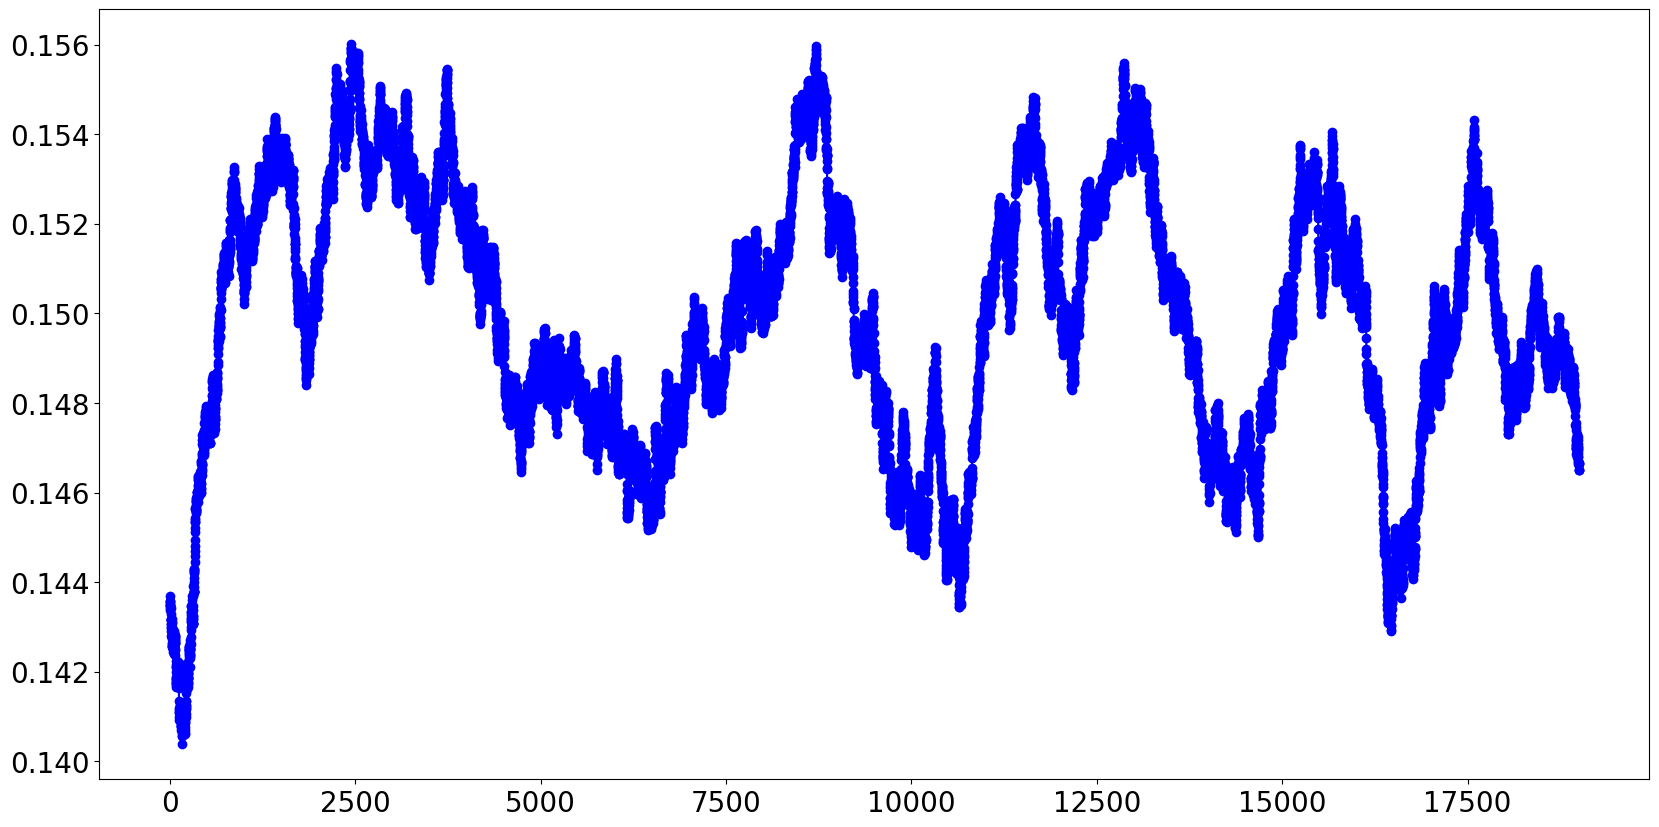

In [64]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams['font.size']=20
plt.plot(moving_average(np.array(Qgrid[agent1.action_history]),1000), label = 'Agent 1 Actions', marker = 'o', c = 'b')
#plt.plot(moving_average(np.array(agent2.action_history),1000), label = 'Agent 2 Actions', marker = 'x', c = 'r')
#plt.title('Fraction of Co-operations in 100 games') 
plt.show()

In [66]:
print(q1c, q2c)

0.30000000000000004 0.30000000000000004
